#### Day 1

In [116]:
import math
import itertools
import re
import json

import numpy as np
import pandas as pd
import networkx as nx

from random import randint
from collections import Counter, defaultdict
from copy import deepcopy

from matplotlib import pyplot as plt

%matplotlib inline

In [86]:
class IntCode_v3:
    def __init__(self, intcode):
        self.intcode = intcode
        self.reset()
    
    def reset(self):
#         self.work_intcode = self.intcode[:]
        self.work_intcode = {idx:val for idx, val in enumerate(self.intcode)} 
        self.output = []
        self.mem = {}
        
    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as file:
            return cls([int(x) for x in file.read().split(',')])
    
    @classmethod
    def test_txt(cls, text, calc, **input_dict):
        test_intcode = cls([int(x) for x in text.split(',')])
        test_intcode.intcodeRead(calc, outmode = 0, **input_dict)
    
    def mode_manage(self, num, mode):
        if mode == 0:
            return self.work_intcode.get(num, 0)
        elif mode == 1:
            return num
        elif mode == 2:
            return self.work_intcode.get(self.mem['relbase'] + num, 0)
    
    def spec_mode_manage(self, num, mode):
        if mode == 0 or mode == 1:
            return num
        elif mode == 2:
            return self.mem['relbase'] + num
                
    def instr_manage(self, selfmem):      
        current_idx =  selfmem['current_idx']
        
        instr_str = str(self.work_intcode.get(current_idx, 0))
        params = {x:int(y) for x, y in enumerate(reversed(instr_str[:len(instr_str)-2]))}
        opcode = instr_str[len(instr_str)-2:]
        
        
#         print(instr_str, opcode)
        if int(opcode) == 1:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            self.work_intcode[output_loc] = param_a + param_b
            
            current_idx += 4
            
        elif int(opcode) == 2:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            self.work_intcode[output_loc] = param_a * param_b
            
            current_idx += 4

        elif int(opcode) == 3: 
            try:
                move_num = self.spec_mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0)) 
                selfmem['inputs'][selfmem['input_idx']]
                self.work_intcode[move_num] = selfmem['inputs'][selfmem['input_idx']]
                
                selfmem['input_idx'] += 1
                current_idx += 2
                
            except IndexError:
#                 print('HALT COMMAND')
                selfmem['midhalt'] = 1
        
        elif int(opcode) == 4:
            val_output = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            self.output.append(val_output)
            
            current_idx += 2
        
        elif int(opcode) == 5:
            check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            if check != 0:
                current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 6:
            check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            if check == 0:
                current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 7:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            if param_a < param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
            
            current_idx += 4
        
        elif int(opcode) == 8:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            if param_a == param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
                
            current_idx += 4
        
        elif int(opcode) == 9:
            rel_adj = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            selfmem['relbase'] += rel_adj
                
            current_idx += 2
        
        return current_idx
       
    def intcodeRead(self, calc, outmode = 1, **input_dict):
        current_idx = 0
        
        if self.mem == {}:
            self.mem = input_dict
            self.mem['input_idx'] = 0
            self.mem['midhalt'] = None
            self.mem['current_idx'] = 0
            self.mem['relbase'] = 0
            
            if isinstance(self.mem.get('inputs',0), int):
                self.mem['inputs'] = [self.mem.get('inputs',0)]
        else:
            self.mem['inputs'] = input_dict['inputs']
            self.mem['midhalt'] = 0
#         print(self.output)
             
        if calc == 'nv':
            print(
                f'Calculating using NOUN/VERB method\n' 
                f'Noun: {nv.get("noun", 0)}\n' 
                f'Verb: {nv.get("verb", 0)}\n' 
                f"Note: If noun or verb used in inputs are > 99, noun and verb default to intcode's default values"
            )
            self.work_intcode[1] = self.mem.get('noun', x[1])
            self.work_intcode[2] = self.mem.get('verb', x[2])
            
        elif calc == 'input':
            print(
#                 f'Calculating using input method\n'
#                 f'Note: Default value if "val" variable not in parameters is 0'
            )
        
        while self.work_intcode.get(self.mem['current_idx'], 0) != 99 and self.mem['midhalt'] != 1:
            self.mem['current_idx'] = self.instr_manage(self.mem)

        reconstituted = [self.work_intcode.get(x, 0) for x in range(max(self.work_intcode)+1)]
        
        if outmode == 1:
            return reconstituted, self.output
        elif outmode == 'output_only':
            return self.output
        elif outmode == 'last_out':
            return self.output[-1]
        else:
#             print(reconstituted, self.output, self.mem.get('inputs'))
            print(self.mem.get('inputs'), self.output)

In [3]:
with open('day01.txt', 'r') as file:
    solution = 0
    for x in file.readlines():
        solution += math.trunc(float(x)/3) -2

solution

3336439

In [4]:
def fuel_calc(num: float) -> float:
    calc = math.trunc(num/3) - 2
    if calc > 0:
        return calc
    else:
        return 0

In [5]:
with open('day01.txt', 'r') as file:
    solution = 0
    for x in file.readlines():
        solution += fuel_calc(float(x))

        add_fuel = fuel_calc(fuel_calc(float(x)))
        solution += add_fuel

        while fuel_calc(add_fuel) > 0: 
            add_fuel = fuel_calc(add_fuel)
            solution += add_fuel

solution

5001791

#### Day 2

In [6]:
with open('day02.txt', 'r') as file:
    intcode = [int(x) for x in file.read().split(',')]
    intcode[1] = 12
    intcode[2] = 2

In [7]:
class IntCode:
    def __init__(self, intcode, noun, verb):
        self.intcode = intcode
        self.noun = noun
        self.verb = verb
    
    @classmethod
    def load_txt(cls, filename):
        with open(filename, 'r') as file:
            return cls(intcode = [int(x) for x in file.read().split(',')], noun = intcode[1], verb = intcode[2])
    
    @staticmethod
    def manual_read(target, test=0):
        x = target[:]
        for num in range(0, len(x), 4):
            current_op = x[num]

            if current_op == 99:
                break
            else:
                input_loc1 = x[num+1]
                input_loc2 = x[num+2]
                output_loc3 = x[num+3]
                if current_op == 1:
                    x[output_loc3] = x[input_loc1] + x[input_loc2]
                elif current_op == 2:
                    x[output_loc3] = x[input_loc1] * x[input_loc2]

            if test == 1:
                break

        return x[0]
    
    def intcodeRead(self, noun=-1, verb=-1, test = 0):
        x = self.intcode[:]
        if noun == -1 or verb == -1:
            print(f'No valid noun/verb pair, using default Noun: {self.noun}, Verb:{self.verb}')
            x[1] = self.noun
            x[2] = self.verb
        else:
            x[1] = noun
            x[2] = verb

        result = self.manual_read(x, test)
        return result

    def brute_force(self, target):
        noun_t = randint(0, 100)
        verb_t = randint(0, 100)
        
        while self.intcodeRead(noun=noun_t, verb=verb_t) != target:
            print(f'Pair noun: {noun_t}, verb: {verb_t}, result = {self.intcodeRead(noun=noun_t, verb=verb_t)}')
            noun_t = randint(0, 100)
            verb_t = randint(0, 100)
            
        print(noun_t, verb_t)

In [8]:
a = IntCode.load_txt('day02.txt')
a.brute_force(19690720)

Pair noun: 32, verb: 63, result = 19114707
Pair noun: 95, verb: 71, result = 55402715
Pair noun: 59, verb: 100, result = 34666744
Pair noun: 52, verb: 25, result = 30634669
Pair noun: 1, verb: 57, result = 1258701
Pair noun: 73, verb: 82, result = 42730726
Pair noun: 17, verb: 44, result = 10474688
Pair noun: 58, verb: 56, result = 34090700
Pair noun: 91, verb: 88, result = 53098732
Pair noun: 77, verb: 99, result = 45034743
Pair noun: 74, verb: 58, result = 43306702
Pair noun: 31, verb: 7, result = 18538651
Pair noun: 90, verb: 51, result = 52522695
Pair noun: 92, verb: 42, result = 53674686
Pair noun: 13, verb: 67, result = 8170711
Pair noun: 83, verb: 80, result = 48490724
Pair noun: 15, verb: 90, result = 9322734
Pair noun: 46, verb: 6, result = 27178650
Pair noun: 55, verb: 69, result = 32362713
Pair noun: 87, verb: 5, result = 50794649
Pair noun: 2, verb: 93, result = 1834737
Pair noun: 52, verb: 48, result = 30634692
Pair noun: 48, verb: 24, result = 28330668
Pair noun: 30, verb

Pair noun: 66, verb: 70, result = 38698714
Pair noun: 66, verb: 84, result = 38698728
Pair noun: 84, verb: 42, result = 49066686
Pair noun: 84, verb: 58, result = 49066702
Pair noun: 90, verb: 49, result = 52522693
Pair noun: 84, verb: 50, result = 49066694
Pair noun: 2, verb: 68, result = 1834712
Pair noun: 97, verb: 37, result = 56554681
Pair noun: 8, verb: 8, result = 5290652
Pair noun: 68, verb: 78, result = 39850722
Pair noun: 41, verb: 27, result = 24298671
Pair noun: 89, verb: 39, result = 51946683
Pair noun: 85, verb: 20, result = 49642664
Pair noun: 62, verb: 12, result = 36394656
Pair noun: 54, verb: 48, result = 31786692
Pair noun: 23, verb: 33, result = 13930677
Pair noun: 97, verb: 87, result = 56554731
Pair noun: 27, verb: 19, result = 16234663
Pair noun: 88, verb: 98, result = 51370742
Pair noun: 50, verb: 69, result = 29482713
Pair noun: 16, verb: 97, result = 9898741
Pair noun: 94, verb: 41, result = 54826685
Pair noun: 93, verb: 38, result = 54250682
Pair noun: 66, ve

Pair noun: 65, verb: 62, result = 38122706
Pair noun: 69, verb: 1, result = 40426645
Pair noun: 71, verb: 83, result = 41578727
Pair noun: 56, verb: 32, result = 32938676
Pair noun: 3, verb: 24, result = 2410668
Pair noun: 23, verb: 40, result = 13930684
Pair noun: 43, verb: 100, result = 25450744
Pair noun: 56, verb: 53, result = 32938697
Pair noun: 70, verb: 59, result = 41002703
Pair noun: 80, verb: 90, result = 46762734
Pair noun: 90, verb: 90, result = 52522734
Pair noun: 79, verb: 94, result = 46186738
Pair noun: 20, verb: 33, result = 12202677
Pair noun: 59, verb: 4, result = 34666648
Pair noun: 61, verb: 12, result = 35818656
Pair noun: 49, verb: 15, result = 28906659
Pair noun: 23, verb: 29, result = 13930673
Pair noun: 13, verb: 55, result = 8170699
Pair noun: 23, verb: 13, result = 13930657
Pair noun: 35, verb: 87, result = 20842731
Pair noun: 78, verb: 17, result = 45610661
Pair noun: 89, verb: 1, result = 51946645
Pair noun: 56, verb: 93, result = 32938737
Pair noun: 76, v

Pair noun: 70, verb: 12, result = 41002656
Pair noun: 8, verb: 54, result = 5290698
Pair noun: 43, verb: 95, result = 25450739
Pair noun: 87, verb: 89, result = 50794733
Pair noun: 39, verb: 65, result = 23146709
Pair noun: 87, verb: 4, result = 50794648
Pair noun: 61, verb: 15, result = 35818659
Pair noun: 76, verb: 63, result = 44458707
Pair noun: 96, verb: 90, result = 55978734
Pair noun: 88, verb: 93, result = 51370737
Pair noun: 41, verb: 100, result = 24298744
Pair noun: 80, verb: 59, result = 46762703
Pair noun: 29, verb: 22, result = 17386666
Pair noun: 36, verb: 98, result = 21418742
Pair noun: 37, verb: 79, result = 21994723
Pair noun: 84, verb: 63, result = 49066707
Pair noun: 56, verb: 16, result = 32938660
Pair noun: 11, verb: 52, result = 7018696
Pair noun: 16, verb: 83, result = 9898727
Pair noun: 66, verb: 41, result = 38698685
Pair noun: 18, verb: 17, result = 11050661
Pair noun: 48, verb: 99, result = 28330743
Pair noun: 90, verb: 31, result = 52522675
Pair noun: 75, 

Pair noun: 12, verb: 88, result = 7594732
Pair noun: 11, verb: 53, result = 7018697
Pair noun: 78, verb: 47, result = 45610691
Pair noun: 7, verb: 79, result = 4714723
Pair noun: 34, verb: 64, result = 20266708
Pair noun: 49, verb: 29, result = 28906673
Pair noun: 69, verb: 96, result = 40426740
Pair noun: 51, verb: 4, result = 30058648
Pair noun: 70, verb: 22, result = 41002666
Pair noun: 0, verb: 38, result = 682682
Pair noun: 73, verb: 23, result = 42730667
Pair noun: 64, verb: 91, result = 37546735
Pair noun: 64, verb: 94, result = 37546738
Pair noun: 16, verb: 56, result = 9898700
Pair noun: 66, verb: 3, result = 38698647
Pair noun: 56, verb: 68, result = 32938712
Pair noun: 10, verb: 22, result = 6442666
Pair noun: 3, verb: 54, result = 2410698
Pair noun: 54, verb: 85, result = 31786729
Pair noun: 9, verb: 82, result = 5866726
Pair noun: 19, verb: 32, result = 11626676
Pair noun: 44, verb: 92, result = 26026736
Pair noun: 28, verb: 77, result = 16810721
Pair noun: 14, verb: 32, r

Pair noun: 33, verb: 96, result = 19690740
Pair noun: 56, verb: 25, result = 32938669
Pair noun: 48, verb: 98, result = 28330742
Pair noun: 33, verb: 1, result = 19690645
Pair noun: 94, verb: 50, result = 54826694
Pair noun: 31, verb: 69, result = 18538713
Pair noun: 66, verb: 34, result = 38698678
Pair noun: 61, verb: 60, result = 35818704
Pair noun: 71, verb: 94, result = 41578738
Pair noun: 1, verb: 11, result = 1258655
Pair noun: 54, verb: 52, result = 31786696
Pair noun: 33, verb: 81, result = 19690725
Pair noun: 81, verb: 100, result = 47338744
Pair noun: 45, verb: 83, result = 26602727
Pair noun: 81, verb: 4, result = 47338648
Pair noun: 62, verb: 19, result = 36394663
Pair noun: 34, verb: 100, result = 20266744
Pair noun: 47, verb: 72, result = 27754716
Pair noun: 45, verb: 34, result = 26602678
Pair noun: 94, verb: 95, result = 54826739
Pair noun: 76, verb: 6, result = 44458650
Pair noun: 77, verb: 19, result = 45034663
Pair noun: 10, verb: 80, result = 6442724
Pair noun: 19, 

Pair noun: 47, verb: 2, result = 27754646
Pair noun: 92, verb: 99, result = 53674743
Pair noun: 82, verb: 75, result = 47914719
Pair noun: 17, verb: 9, result = 10474653
Pair noun: 44, verb: 51, result = 26026695
Pair noun: 52, verb: 77, result = 30634721
Pair noun: 15, verb: 80, result = 9322724
Pair noun: 62, verb: 69, result = 36394713
Pair noun: 3, verb: 91, result = 2410735
Pair noun: 81, verb: 72, result = 47338716
Pair noun: 31, verb: 73, result = 18538717
Pair noun: 13, verb: 31, result = 8170675
Pair noun: 62, verb: 30, result = 36394674
Pair noun: 69, verb: 62, result = 40426706
Pair noun: 40, verb: 3, result = 23722647
Pair noun: 87, verb: 60, result = 50794704
Pair noun: 75, verb: 39, result = 43882683
Pair noun: 68, verb: 89, result = 39850733
Pair noun: 3, verb: 67, result = 2410711
Pair noun: 54, verb: 44, result = 31786688
Pair noun: 100, verb: 46, result = 58282690
Pair noun: 56, verb: 36, result = 32938680
Pair noun: 79, verb: 99, result = 46186743
Pair noun: 71, verb

Pair noun: 49, verb: 68, result = 28906712
Pair noun: 53, verb: 47, result = 31210691
Pair noun: 34, verb: 73, result = 20266717
Pair noun: 20, verb: 10, result = 12202654
Pair noun: 26, verb: 80, result = 15658724
Pair noun: 2, verb: 76, result = 1834720
Pair noun: 44, verb: 74, result = 26026718
Pair noun: 37, verb: 20, result = 21994664
Pair noun: 20, verb: 10, result = 12202654
Pair noun: 95, verb: 75, result = 55402719
Pair noun: 31, verb: 64, result = 18538708
Pair noun: 61, verb: 35, result = 35818679
Pair noun: 63, verb: 4, result = 36970648
Pair noun: 65, verb: 99, result = 38122743
Pair noun: 61, verb: 25, result = 35818669
Pair noun: 96, verb: 12, result = 55978656
Pair noun: 4, verb: 60, result = 2986704
Pair noun: 100, verb: 93, result = 58282737
Pair noun: 86, verb: 65, result = 50218709
Pair noun: 97, verb: 34, result = 56554678
Pair noun: 24, verb: 33, result = 14506677
Pair noun: 39, verb: 94, result = 23146738
Pair noun: 37, verb: 88, result = 21994732
Pair noun: 21, 

#### Day 3

In [9]:
def line_point_cov(string) -> list:
    # ref
    ref = {'R': np.array([1,0]), 'L': np.array([-1,0]), 'U': np.array([0,1]), 'D': np.array([0,-1])}
    
    # clean
    line = [aa.strip() for aa in string.split(',')]
    current_pos = np.array([0,0])    
    
    point_list = [] #from position 1 to end
    endpoints = [current_pos]
    
    for a in line:
        delta = ref[a[0]] * int(a[1:])
        new_pos = current_pos + delta
        
        collect_x = [current_pos[0], new_pos[0]]
        collect_y = [current_pos[1], new_pos[1]]
        
        point_list.extend([(x,y) for x in range(min(collect_x),max(collect_x)+1,1) for y in range(min(collect_y),max(collect_y)+1,1)])
        endpoints.append(new_pos)
        
        current_pos = new_pos
        
    return point_list, endpoints

In [10]:
with open('day03.txt', 'r') as file:
    point_1, end_1 = line_point_cov(file.readline())
    point_2, end_2 = line_point_cov(file.readline())
    line_1 = set(point_1)
    line_2 = set(point_2)

In [11]:
sorted([(x, abs(x[0])+abs(x[1])) for x in line_1.intersection(line_2)], key = lambda x: x[1])

[((0, 0), 0),
 ((-610, 675), 1285),
 ((-517, 777), 1294),
 ((-274, 1105), 1379),
 ((-886, 557), 1443),
 ((-771, 675), 1446),
 ((-274, 1269), 1543),
 ((-999, 557), 1556),
 ((-274, 1286), 1560),
 ((-309, 1411), 1720),
 ((-557, 1201), 1758),
 ((-771, 987), 1758),
 ((-490, 1269), 1759),
 ((-1648, 112), 1760),
 ((-490, 1286), 1776),
 ((-517, 1269), 1786),
 ((-517, 1286), 1803),
 ((-1728, -115), 1843),
 ((-1320, 536), 1856),
 ((-1753, 112), 1865),
 ((-1470, 536), 2006),
 ((-1753, 282), 2035),
 ((-751, 1286), 2037),
 ((-1648, 413), 2061),
 ((-905, 1201), 2106),
 ((-905, 1258), 2163),
 ((-905, 1267), 2172),
 ((-766, 1509), 2275),
 ((-766, 1526), 2292),
 ((-899, 1506), 2405),
 ((-1444, 1051), 2495),
 ((-2674, -53), 2727),
 ((-714, 2037), 2751),
 ((-2674, -237), 2911),
 ((-648, 2290), 2938),
 ((-714, 2290), 3004),
 ((-3076, -53), 3129),
 ((-3110, -53), 3163),
 ((-880, 2290), 3170),
 ((-3429, -97), 3526),
 ((-3429, -198), 3627),
 ((-1944, 1899), 3843),
 ((-3857, -97), 3954),
 ((-3857, -198), 4055

In [12]:
endcop = end_1[1:]
intersections = line_1.intersection(line_2)
intersections.remove((0,0))
new_end1 = [np.array([0, 0])]

for a in endcop:
    for point in intersections:
        align_x = point[0] == new_end1[-1][0]
        align_y = point[1] == new_end1[-1][1]
        
        mod_x = abs(point[0] - new_end1[-1][0])
        mod_y = abs(point[1] - new_end1[-1][1])
        
        if (align_x and mod_y) or (align_y and mod_x):
            new_end1.append(point)
        
    new_end1.append(a)
        

In [13]:
def line_rebuild(endpoints, intersections):
    completed = []

    for a, b in zip(endpoints, endpoints[1:]):
        change_x = abs(a[0] - b[0]) > 0  
        change_y = abs(a[1] - b[1]) > 0  
        intersecting = [a]
        flag_key = None

        for point in intersections:
            align_x = point[0] == a[0]
            align_y = point[1] == a[1]

            if change_x and align_y:
                intersecting.append(np.array(point))
                flag_key = 0
            elif change_y and align_x:
                intersecting.append(np.array(point))
                flag_key = 1

        key_1 = a[flag_key]
        key_2 = b[flag_key]

        if flag_key != None:
            flag_order = True if key_1 > key_2 else False
            intersecting = sorted(intersecting, reverse=flag_order, key = lambda x: x[flag_key])

        completed.extend(intersecting)

    return completed

In [14]:
intersections = line_1.intersection(line_2)
intersections.remove((0,0))

line_rebuild(end_1, intersections)

[array([0, 0]),
 array([995,   0]),
 array([ 995, -933]),
 array([ 711, -933]),
 array([ 711, -353]),
 array([1164, -353]),
 array([1164,    2]),
 array([812,   2]),
 array([812, 365]),
 array([306, 365]),
 array([306, 235]),
 array([606, 235]),
 array([606, 123]),
 array([-145,  123]),
 array([-145,  368]),
 array([ 29, 368]),
 array([  29, 1269]),
 array([-274, 1269]),
 array([-490, 1269]),
 array([-517, 1269]),
 array([-557, 1269]),
 array([-557, 1201]),
 array([-557, 1199]),
 array([-905, 1199]),
 array([-905, 1201]),
 array([-905, 1258]),
 array([-905, 1267]),
 array([-905, 1506]),
 array([-899, 1506]),
 array([-309, 1506]),
 array([-309, 1411]),
 array([-309, 1105]),
 array([-274, 1105]),
 array([   2, 1105]),
 array([  2, 777]),
 array([-517,  777]),
 array([-610,  777]),
 array([-610,  675]),
 array([-610,  563]),
 array([-771,  563]),
 array([-771,  675]),
 array([-771,  987]),
 array([-771, 1051]),
 array([-1444,  1051]),
 array([-1584,  1051]),
 array([-1584,  1349]),
 array

In [15]:
new_line_1 = line_rebuild(end_1, intersections)
new_line_2 = line_rebuild(end_2, intersections)
final_answer3 = {}

for point in intersections:
    up_to_intersect1 = new_line_1[0:[np.array_equal(point,x) for x in new_line_1].index(True) + 1]
    up_to_intersect2 = new_line_2[0:[np.array_equal(point,x) for x in new_line_2].index(True) + 1]
    
    line1_dist = sum([np.sum(abs(a - b)) for a, b in zip(up_to_intersect1, up_to_intersect1[1:])])
    line2_dist = sum([np.sum(abs(a - b)) for a, b in zip(up_to_intersect2, up_to_intersect2[1:])])
    
    final_answer3[point] = line1_dist+line2_dist

In [16]:
final_answer3[min(final_answer3, key=final_answer3.get)]

14228

#### Day 4

In [17]:
## INPUT RANGE FOR PASSWORD 254032-789860
def pass_check(num):
    str_form = str(num)
    flag1 = 0
    flag2 = 1
    
    # never decreases
    for val in range(len(str_form)-1):
        if str_form[val] == str_form[val+1]:
            flag1 = 1
        if int(str_form[val]) > int(str_form[val+1]):
            flag2 = 0
    
    if flag1 == 1 and flag2 == 1:
        return num
    else:
        return None

In [18]:
match_pass = 0
for number in range(254032, 789860+1, 1):
    if pass_check(number):
        match_pass += 1
match_pass

1033

In [19]:
## INPUT RANGE FOR PASSWORD 254032-789860
def modified_pass_check(num):
    str_form = str(num)
    count = Counter(str_form)
    flag1 = 0
    flag2 = 1
    
    # never decreases
    for val in range(len(str_form)-1):
        if str_form[val] == str_form[val+1] and count[str_form[val]] == 2:
            flag1 = 1
        if int(str_form[val]) > int(str_form[val+1]):
            flag2 = 0
    
    if flag1 == 1 and flag2 == 1:
        return num
    else:
        return None

In [20]:
match_pass = 0
for number in range(254032, 789860+1, 1):
    if modified_pass_check(number):
        match_pass += 1
match_pass

670

#### Day 5

In [21]:
class IntCode_v2:
    def __init__(self, intcode):
        self.intcode = intcode
        self.reset()
    
    def reset(self):
        self.work_intcode = self.intcode[:]
        self.output = []
        self.mem = {}
        
    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as file:
            return cls([int(x) for x in file.read().split(',')])
    
    @classmethod
    def test_txt(cls, text, calc, **input_dict):
        test_intcode = cls([int(x) for x in text.split(',')])
        test_intcode.intcodeRead(calc, outmode = 0, **input_dict)
    
    def mode_manage(self, num, mode):
        if mode == 0:
            return self.work_intcode[num]
        elif mode == 1:
            return num
    
    
    def instr_manage(self, selfmem):      
        current_idx =  selfmem['current_idx']
        
        instr_str = str(self.work_intcode[selfmem['current_idx']])
        params = {x:int(y) for x, y in enumerate(reversed(instr_str[:len(instr_str)-2]))}
        opcode = instr_str[len(instr_str)-2:]
        
        
#         print(instr_str, opcode)
        
        print(self.work_intcode[current_idx:current_idx+4])
        if int(opcode) == 1:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            self.work_intcode[output_loc] = param_a + param_b
            
            current_idx += 4
            
        elif int(opcode) == 2:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            self.work_intcode[output_loc] = param_a * param_b
            
            current_idx += 4

        elif int(opcode) == 3: 
            try:
                move_num = self.work_intcode[current_idx + 1]            
                self.work_intcode[move_num] = selfmem['inputs'][selfmem['input_idx']]
                selfmem['input_idx'] += 1
            
                current_idx += 2
            except IndexError:
                selfmem['midhalt'] = 1
        
        elif int(opcode) == 4:
            val_output = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            self.output.append(val_output)
            
            current_idx += 2
        
        elif int(opcode) == 5:
            check = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            
            if check != 0:
                current_idx = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 6:
            check = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            
            if check == 0:
                current_idx = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 7:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            if param_a < param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
            
            current_idx += 4
        
        elif int(opcode) == 8:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            if param_a == param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
                
            current_idx += 4
        return current_idx
       
    def intcodeRead(self, calc, outmode = 1, **input_dict):
        current_idx = 0
        
        if self.mem == {}:
            self.mem = input_dict
            self.mem['input_idx'] = 0
            self.mem['midhalt'] = None
            self.mem['current_idx'] = 0
            
            if isinstance(self.mem['inputs'], int):
                self.mem['inputs'] = [self.mem['inputs']]
        else:
            self.mem['inputs'] = input_dict['inputs']
            self.mem['midhalt'] = 0
#         print(self.output)
             
        if calc == 'nv':
            print(
                f'Calculating using NOUN/VERB method\n' 
                f'Noun: {nv.get("noun", 0)}\n' 
                f'Verb: {nv.get("verb", 0)}\n' 
                f"Note: If noun or verb used in inputs are > 99, noun and verb default to intcode's default values"
            )
            self.work_intcode[1] = self.mem.get('noun', x[1])
            self.work_intcode[2] = self.mem.get('verb', x[2])
            
        elif calc == 'input':
            print(
                f'Calculating using input method\n'
                f'Note: Default value if "val" variable not in parameters is 0'
            )
        
        while self.work_intcode[self.mem['current_idx']] != 99 and self.mem['midhalt'] != 1:
            print(self.mem['current_idx'])
            self.mem['current_idx'] = self.instr_manage(self.mem)


        if outmode == 1:
            return self.work_intcode, self.output
        elif outmode == 'output_only':
            return self.output
        else:
            print(self.work_intcode, self.output, self.mem.get('inputs'))

In [22]:
day5 = IntCode_v2.load('day05.txt')
day5.intcodeRead('input', outmode = 0, inputs = 1)

Calculating using input method
Note: Default value if "val" variable not in parameters is 0
0
[3, 225, 1, 225]
2
[1, 225, 6, 6]
6
[1101, 1, 238, 225]
10
[104, 0, 1101, 37]
12
[1101, 37, 61, 225]
16
[101, 34, 121, 224]
20
[1001, 224, -49, 224]
24
[4, 224, 102, 8]
26
[102, 8, 223, 223]
30
[1001, 224, 6, 224]
34
[1, 224, 223, 223]
38
[1101, 67, 29, 225]
42
[1, 14, 65, 224]
46
[101, -124, 224, 224]
50
[4, 224, 1002, 223]
52
[1002, 223, 8, 223]
56
[101, 5, 224, 224]
60
[1, 224, 223, 223]
64
[1102, 63, 20, 225]
68
[1102, 27, 15, 225]
72
[1102, 18, 79, 224]
76
[101, -1422, 224, 224]
80
[4, 224, 102, 8]
82
[102, 8, 223, 223]
86
[1001, 224, 1, 224]
90
[1, 223, 224, 223]
94
[1102, 20, 44, 225]
98
[1001, 69, 5, 224]
102
[101, -32, 224, 224]
106
[4, 224, 1002, 223]
108
[1002, 223, 8, 223]
112
[101, 1, 224, 224]
116
[1, 223, 224, 223]
120
[1102, 15, 10, 225]
124
[1101, 6, 70, 225]
128
[102, 86, 40, 224]
132
[101, -2494, 224, 224]
136
[4, 224, 1002, 223]
138
[1002, 223, 8, 223]
142
[101, 6, 224, 224

In [23]:
day5.reset()
day5.intcodeRead('input', outmode = 'output_only', inputs = 1)

Calculating using input method
Note: Default value if "val" variable not in parameters is 0
0
[3, 225, 1, 225]
2
[1, 225, 6, 6]
6
[1101, 1, 238, 225]
10
[104, 0, 1101, 37]
12
[1101, 37, 61, 225]
16
[101, 34, 121, 224]
20
[1001, 224, -49, 224]
24
[4, 224, 102, 8]
26
[102, 8, 223, 223]
30
[1001, 224, 6, 224]
34
[1, 224, 223, 223]
38
[1101, 67, 29, 225]
42
[1, 14, 65, 224]
46
[101, -124, 224, 224]
50
[4, 224, 1002, 223]
52
[1002, 223, 8, 223]
56
[101, 5, 224, 224]
60
[1, 224, 223, 223]
64
[1102, 63, 20, 225]
68
[1102, 27, 15, 225]
72
[1102, 18, 79, 224]
76
[101, -1422, 224, 224]
80
[4, 224, 102, 8]
82
[102, 8, 223, 223]
86
[1001, 224, 1, 224]
90
[1, 223, 224, 223]
94
[1102, 20, 44, 225]
98
[1001, 69, 5, 224]
102
[101, -32, 224, 224]
106
[4, 224, 1002, 223]
108
[1002, 223, 8, 223]
112
[101, 1, 224, 224]
116
[1, 223, 224, 223]
120
[1102, 15, 10, 225]
124
[1101, 6, 70, 225]
128
[102, 86, 40, 224]
132
[101, -2494, 224, 224]
136
[4, 224, 1002, 223]
138
[1002, 223, 8, 223]
142
[101, 6, 224, 224

[0, 0, 0, 0, 0, 0, 0, 0, 0, 13933662]

In [24]:
# day5_2 = IntCode_v2.test_txt('3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,\
# 1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,\
# 999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99', calc='input', inputs=9)

day5_v2 = IntCode_v2.load('day05.txt')
day5_v2.intcodeRead('input', outmode = 0, inputs=5)

Calculating using input method
Note: Default value if "val" variable not in parameters is 0
0
[3, 225, 1, 225]
2
[1, 225, 6, 6]
6
[1105, 1, 238, 225]
238
[1105, 0, 99999, 1105]
241
[1105, 227, 247, 1105]
247
[1005, 227, 99999, 1005]
250
[1005, 0, 256, 1105]
256
[1106, 227, 99999, 1106]
259
[1106, 0, 265, 1105]
265
[1006, 0, 99999, 1006]
268
[1006, 227, 274, 1105]
274
[1105, 1, 280, 1105]
280
[1, 225, 225, 225]
284
[1101, 294, 0, 0]
288
[105, 1, 0, 1105]
294
[1106, 0, 300, 1105]
300
[1, 225, 225, 225]
304
[1101, 314, 0, 0]
308
[106, 0, 0, 1105]
314
[108, 677, 677, 224]
318
[1002, 223, 2, 223]
322
[1006, 224, 329, 101]
329
[1107, 677, 226, 224]
333
[102, 2, 223, 223]
337
[1006, 224, 344, 101]
344
[8, 677, 677, 224]
348
[1002, 223, 2, 223]
352
[1006, 224, 359, 101]
355
[101, 1, 223, 223]
359
[1008, 677, 677, 224]
363
[1002, 223, 2, 223]
367
[1006, 224, 374, 101]
374
[7, 226, 677, 224]
378
[1002, 223, 2, 223]
382
[1006, 224, 389, 1001]
389
[1007, 677, 677, 224]
393
[1002, 223, 2, 223]
397


#### Day 6

In [25]:
G = nx.read_adjlist('day06.txt', delimiter = ')')

In [26]:
sum(nx.shortest_path_length(G, target = 'COM').values())

171213

In [27]:
#'YOU' node orbiting 
print(G['YOU'])
#'SAN' node orbitinh
print(G['SAN'])

{'9XB': {}}
{'B2L': {}}


In [28]:
nx.shortest_path_length(G, source='9XB', target = 'B2L')

292

#### Day 7

##### Part 1

In [29]:
class Amplif_ensem():
    def __init__(self, intcode):
        self.intcode = intcode
        self.reset()
        
    def reset(self):
        self.A1, self.A2, self.A3, self.A4, self.A5 = [IntCode_v3(self.intcode[:]) for _ in range(5)]
    
    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as file:
            return cls([int(x) for x in file.read().split(',')])
    
    @classmethod
    def test_txt(cls, intcode, phase_seq, mode = 'series'):
        test_intcode = cls([int(x) for x in intcode.split(',')])
        if mode == 'series':
            test_intcode.phase_calc(phase_seq)
        elif mode == 'loop':
            test_intcode.feedback_calc(phase_seq)
        
    def phase_calc(self, phase_seq):
        print(self.intcode)
        phase = iter([int(x) for x in phase_seq.split(',')])
        
        o1 = self.A1.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), 0])[0]
        print('amp1', o1, self.A1.work_intcode, '\n')
        
        o2 = self.A2.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o1])[0]
        print('amp2', o2, self.A2.work_intcode, '\n')
        
        o3 = self.A3.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o2])[0]
        print('amp3', o3, self.A3.work_intcode, '\n')
        
        o4 = self.A4.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o3])[0]
        print('amp4', o4, self.A4.work_intcode, '\n')
        
        o5 = self.A5.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o4])[0]
        print('amp5',o5, self.A5.work_intcode, '\n')
        
        print(f'OUTPUT TO THRUSTER: {o5}')
        return o5
    
    def phase_seq_find(self, mode = 'series'):
        self.reset()
        options = {'series': {'phase': ['0','1','2','3','4'], 'func': self.phase_calc},
                   'loop': {'phase': ['5','6','7','8','9'], 'func': self.feedback_calc}}
        max_a = {}
        
        phasecodes = iter([','.join(list(perm)) for perm in (itertools.permutations(options[mode]['phase'], 5))])
        for phase_code in phasecodes:
            self.reset()
            thrust = options[mode]['func'](phase_code)
            max_a[phase_code] = thrust
            
        best_code = [sorted(max_a, key=max_a.get, reverse=True)[0]]
        print(best_code, max_a[','.join(best_code)])
        
        return max_a

    def feedback_calc(self, phase_seq):
        print(self.intcode)

        phase = [int(x) for x in phase_seq.split(',')]
        o5 = None
        
        while self.A5.mem.get('midhalt', 1) == 1:
            if o5:
                o1 = self.A1.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[0], 0, *o5])
            else:
                o1 = self.A1.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[0], 0])
            
            o2 = self.A2.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[1], *o1])

            o3 = self.A3.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[2], *o2])

            o4 = self.A4.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[3], *o3])

            o5 = self.A5.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[4], *o4])
            print(self.A1.mem, self.A5.mem)
        print(f'OUTPUT TO THRUSTER: {o5[-1]}')
        return o5[-1]

In [30]:
Amplif_ensem.test_txt('3,15,3,16,1002,16,10,16,1,16,15,15,4,15,99,0,0', '4,3,2,1,0')

[3, 15, 3, 16, 1002, 16, 10, 16, 1, 16, 15, 15, 4, 15, 99, 0, 0]

amp1 4 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 4, 16: 0} 


amp2 43 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 43, 16: 40} 


amp3 432 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 432, 16: 430} 


amp4 4321 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 4321, 16: 4320} 


amp5 43210 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 43210, 16: 43210} 

OUTPUT TO THRUSTER: 43210


In [31]:
Amplif_ensem.test_txt('3,23,3,24,1002,24,10,24,1002,23,-1,23,\
101,5,23,23,1,24,23,23,4,23,99,0,0', '0,1,2,3,4')

[3, 23, 3, 24, 1002, 24, 10, 24, 1002, 23, -1, 23, 101, 5, 23, 23, 1, 24, 23, 23, 4, 23, 99, 0, 0]

amp1 5 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 5, 24: 0} 


amp2 54 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 54, 24: 50} 


amp3 543 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 543, 24: 540} 


amp4 5432 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 5432, 24: 5430} 


amp5 54321 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10

In [32]:
amplif_calc = Amplif_ensem.load('day07.txt')
result_output = amplif_calc.phase_seq_find()

[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9,

amp2 40 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 10, 9: 40, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 127: 

amp3 5199 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 12, 9: 5199, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 1

amp5 224928 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 11, 9: 224928, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 

amp1 50 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 13, 9: 50, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 127: 

[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9,

OUTPUT TO THRUSTER: 234560
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 99, 3, 9,

##### Part 2

In [33]:
Amplif_ensem.test_txt('3,52,1001,52,-5,52,3,53,1,52,56,54,1007,54,5,55,1005,55,26,1001,54,\
-5,54,1105,1,12,1,53,54,53,1008,54,0,55,1001,55,1,55,2,53,55,53,4,\
53,1001,56,-1,56,1005,56,6,99,0,0,0,0,10', '9,7,8,5,6',  mode='loop')

[3, 52, 1001, 52, -5, 52, 3, 53, 1, 52, 56, 54, 1007, 54, 5, 55, 1005, 55, 26, 1001, 54, -5, 54, 1105, 1, 12, 1, 53, 54, 53, 1008, 54, 0, 55, 1001, 55, 1, 55, 2, 53, 55, 53, 4, 53, 1001, 56, -1, 56, 1005, 56, 6, 99, 0, 0, 0, 0, 10]





{'inputs': [9, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 6, 'relbase': 0} {'inputs': [6, 18], 'input_idx': 2, 'midhalt': 1, 'current_idx': 6, 'relbase': 0}





{'inputs': [9, 0, 19], 'input_idx': 3, 'midhalt': 1, 'current_idx': 6, 'relbase': 0} {'inputs': [6, 18, 29], 'input_idx': 3, 'midhalt': 1, 'current_idx': 6, 'relbase': 0}





{'inputs': [9, 0, 19, 58], 'input_idx': 4, 'midhalt': 1, 'current_idx': 6, 'relbase': 0} {'inputs': [6, 18, 29, 124], 'input_idx': 4, 'midhalt': 1, 'current_idx': 6, 'relbase': 0}





{'inputs': [9, 0, 19, 58, 128], 'input_idx': 5, 'midhalt': 1, 'current_idx': 6, 'relbase': 0} {'inputs': [6, 18, 29, 124, 268], 'input_idx': 5, 'midhalt': 1, 'current_idx': 6, 'relbase': 0}





{'inputs': [9, 0, 19, 58, 128, 271], 'i

In [34]:
loop_output = amplif_calc.phase_seq_find('loop')

[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9,

{'inputs': [5, 0, 6, 52], 'input_idx': 4, 'midhalt': 1, 'current_idx': 142, 'relbase': 0} {'inputs': [9, 3, 50, 417], 'input_idx': 4, 'midhalt': 1, 'current_idx': 466, 'relbase': 0}





{'inputs': [5, 0, 6, 52, 418], 'input_idx': 5, 'midhalt': 1, 'current_idx': 150, 'relbase': 0} {'inputs': [9, 3, 50, 417, 845], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0}





{'inputs': [5, 0, 6, 52, 418, 1690], 'input_idx': 6, 'midhalt': 1, 'current_idx': 158, 'relbase': 0} {'inputs': [9, 3, 50, 417, 845, 13524], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0}





{'inputs': [5, 0, 6, 52, 418, 1690, 13526], 'input_idx': 7, 'midhalt': 1, 'current_idx': 166, 'relbase': 0} {'inputs': [9, 3, 50, 417, 845, 13524, 54108], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0}





{'inputs': [5, 0, 6, 52, 418, 1690, 13526, 54109], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0} {'inputs': [9, 3, 50, 417, 845, 13524, 54108, 108222], 'input_idx':



{'inputs': [5, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 126, 'relbase': 0} {'inputs': [8, 4], 'input_idx': 2, 'midhalt': 1, 'current_idx': 369, 'relbase': 0}





{'inputs': [5, 0, 5], 'input_idx': 3, 'midhalt': 1, 'current_idx': 134, 'relbase': 0} {'inputs': [8, 4, 26], 'input_idx': 3, 'midhalt': 1, 'current_idx': 377, 'relbase': 0}





{'inputs': [5, 0, 5, 52], 'input_idx': 4, 'midhalt': 1, 'current_idx': 142, 'relbase': 0} {'inputs': [8, 4, 26, 211], 'input_idx': 4, 'midhalt': 1, 'current_idx': 385, 'relbase': 0}





{'inputs': [5, 0, 5, 52, 422], 'input_idx': 5, 'midhalt': 1, 'current_idx': 150, 'relbase': 0} {'inputs': [8, 4, 26, 211, 854], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0}





{'inputs': [5, 0, 5, 52, 422, 1708], 'input_idx': 6, 'midhalt': 1, 'current_idx': 158, 'relbase': 0} {'inputs': [8, 4, 26, 211, 854, 13666], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0}





{'inputs': [5, 0, 5, 52, 422, 1708, 13668], 'input_idx'

{'inputs': [5, 0, 5, 48, 388, 1564, 12524, 50106], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0} {'inputs': [6, 4, 24, 194, 1562, 6262, 25053, 100216], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0}





{'inputs': [5, 0, 5, 48, 388, 1564, 12524, 50106, 100217], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0} {'inputs': [6, 4, 24, 194, 1562, 6262, 25053, 100216, 200441], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0}





{'inputs': [5, 0, 5, 48, 388, 1564, 12524, 50106, 100217, 400882], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0} {'inputs': [6, 4, 24, 194, 1562, 6262, 25053, 100216, 200441, 801768], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0}





{'inputs': [5, 0, 5, 48, 388, 1564, 12524, 50106, 100217, 400882, 801769], 'input_idx': 11, 'midhalt': 0, 'current_idx': 198, 'relbase': 0} {'inputs': [6, 4, 24, 194, 1562, 6262, 25053, 100216, 200441, 801768, 3207079], 'input_idx': 


{'inputs': [5, 0, 3, 40, 328, 1324, 10604], 'input_idx': 7, 'midhalt': 1, 'current_idx': 166, 'relbase': 0} {'inputs': [6, 2, 20, 164, 1322, 5302, 21213], 'input_idx': 7, 'midhalt': 1, 'current_idx': 247, 'relbase': 0}





{'inputs': [5, 0, 3, 40, 328, 1324, 10604, 42426], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0} {'inputs': [6, 2, 20, 164, 1322, 5302, 21213, 84856], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0}





{'inputs': [5, 0, 3, 40, 328, 1324, 10604, 42426, 84857], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0} {'inputs': [6, 2, 20, 164, 1322, 5302, 21213, 84856, 169721], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0}





{'inputs': [5, 0, 3, 40, 328, 1324, 10604, 42426, 84857, 339442], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0} {'inputs': [6, 2, 20, 164, 1322, 5302, 21213, 84856, 169721, 678888], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0}





{'inputs': [5

{'inputs': [6, 0, 7], 'input_idx': 3, 'midhalt': 1, 'current_idx': 215, 'relbase': 0} {'inputs': [8, 6, 32], 'input_idx': 3, 'midhalt': 1, 'current_idx': 377, 'relbase': 0}





{'inputs': [6, 0, 7, 64], 'input_idx': 4, 'midhalt': 1, 'current_idx': 223, 'relbase': 0} {'inputs': [8, 6, 32, 258], 'input_idx': 4, 'midhalt': 1, 'current_idx': 385, 'relbase': 0}





{'inputs': [6, 0, 7, 64, 516], 'input_idx': 5, 'midhalt': 1, 'current_idx': 231, 'relbase': 0} {'inputs': [8, 6, 32, 258, 1042], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0}





{'inputs': [6, 0, 7, 64, 516, 2084], 'input_idx': 6, 'midhalt': 1, 'current_idx': 239, 'relbase': 0} {'inputs': [8, 6, 32, 258, 1042, 16674], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0}





{'inputs': [6, 0, 7, 64, 516, 2084, 16676], 'input_idx': 7, 'midhalt': 1, 'current_idx': 247, 'relbase': 0} {'inputs': [8, 6, 32, 258, 1042, 16674, 66707], 'input_idx': 7, 'midhalt': 1, 'current_idx': 409, 'relbase': 0}





{



{'inputs': [6, 0, 12, 106, 853, 3428], 'input_idx': 6, 'midhalt': 1, 'current_idx': 239, 'relbase': 0} {'inputs': [9, 6, 104, 852, 1714, 27428], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0}





{'inputs': [6, 0, 12, 106, 853, 3428, 27430], 'input_idx': 7, 'midhalt': 1, 'current_idx': 247, 'relbase': 0} {'inputs': [9, 6, 104, 852, 1714, 27428, 109728], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0}





{'inputs': [6, 0, 12, 106, 853, 3428, 27430, 109729], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0} {'inputs': [9, 6, 104, 852, 1714, 27428, 109728, 219466], 'input_idx': 8, 'midhalt': 1, 'current_idx': 498, 'relbase': 0}





{'inputs': [6, 0, 12, 106, 853, 3428, 27430, 109729, 219467], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0} {'inputs': [9, 6, 104, 852, 1714, 27428, 109728, 219466, 877871], 'input_idx': 9, 'midhalt': 1, 'current_idx': 506, 'relbase': 0}





{'inputs': [6, 0, 12, 106, 853, 3428, 27430, 1097

{'inputs': [6, 0, 10, 84, 674], 'input_idx': 5, 'midhalt': 1, 'current_idx': 231, 'relbase': 0} {'inputs': [9, 5, 82, 673, 1355], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0}





{'inputs': [6, 0, 10, 84, 674, 2710], 'input_idx': 6, 'midhalt': 1, 'current_idx': 239, 'relbase': 0} {'inputs': [9, 5, 82, 673, 1355, 21688], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0}





{'inputs': [6, 0, 10, 84, 674, 2710, 21690], 'input_idx': 7, 'midhalt': 1, 'current_idx': 247, 'relbase': 0} {'inputs': [9, 5, 82, 673, 1355, 21688, 86766], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0}





{'inputs': [6, 0, 10, 84, 674, 2710, 21690, 86767], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0} {'inputs': [9, 5, 82, 673, 1355, 21688, 86766, 173541], 'input_idx': 8, 'midhalt': 1, 'current_idx': 498, 'relbase': 0}





{'inputs': [6, 0, 10, 84, 674, 2710, 21690, 86767, 173542], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0






{'inputs': [6, 0, 12, 104, 836, 3356, 26860, 107450], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0} {'inputs': [5, 6, 52, 418, 3354, 13430, 53725, 107455], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0}





{'inputs': [6, 0, 12, 104, 836, 3356, 26860, 107450, 214910], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0} {'inputs': [5, 6, 52, 418, 3354, 13430, 53725, 107455, 859643], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0}





{'inputs': [6, 0, 12, 104, 836, 3356, 26860, 107450, 214910, 859645], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0} {'inputs': [5, 6, 52, 418, 3354, 13430, 53725, 107455, 859643, 859650], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0}





{'inputs': [6, 0, 12, 104, 836, 3356, 26860, 107450, 214910, 859645, 1719300], 'input_idx': 11, 'midhalt': 0, 'current_idx': 279, 'relbase': 0} {'inputs': [5, 6, 52, 418, 3354, 13430, 53725, 107455, 859643, 859650, 6

{'inputs': [7, 0, 8, 82, 665, 2680, 21444, 85787], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0} {'inputs': [9, 4, 80, 664, 1340, 21442, 85786, 171579], 'input_idx': 8, 'midhalt': 1, 'current_idx': 498, 'relbase': 0}





{'inputs': [7, 0, 8, 82, 665, 2680, 21444, 85787, 171580], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0} {'inputs': [9, 4, 80, 664, 1340, 21442, 85786, 171579, 686325], 'input_idx': 9, 'midhalt': 1, 'current_idx': 506, 'relbase': 0}





{'inputs': [7, 0, 8, 82, 665, 2680, 21444, 85787, 171580, 686326], 'input_idx': 10, 'midhalt': 1, 'current_idx': 352, 'relbase': 0} {'inputs': [9, 4, 80, 664, 1340, 21442, 85786, 171579, 686325, 1372656], 'input_idx': 10, 'midhalt': 1, 'current_idx': 514, 'relbase': 0}





{'inputs': [7, 0, 8, 82, 665, 2680, 21444, 85787, 171580, 686326, 1372658], 'input_idx': 11, 'midhalt': 0, 'current_idx': 360, 'relbase': 0} {'inputs': [9, 4, 80, 664, 1340, 21442, 85786, 171579, 686325, 1372656, 10981272], 'inpu

{'inputs': [7, 0, 6, 72, 588], 'input_idx': 5, 'midhalt': 1, 'current_idx': 312, 'relbase': 0} {'inputs': [8, 5, 36, 294, 1184], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0}





{'inputs': [7, 0, 6, 72, 588, 2368], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0} {'inputs': [8, 5, 36, 294, 1184, 18948], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0}





{'inputs': [7, 0, 6, 72, 588, 2368, 18950], 'input_idx': 7, 'midhalt': 1, 'current_idx': 328, 'relbase': 0} {'inputs': [8, 5, 36, 294, 1184, 18948, 75810], 'input_idx': 7, 'midhalt': 1, 'current_idx': 409, 'relbase': 0}





{'inputs': [7, 0, 6, 72, 588, 2368, 18950, 75812], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0} {'inputs': [8, 5, 36, 294, 1184, 18948, 75810, 151628], 'input_idx': 8, 'midhalt': 1, 'current_idx': 417, 'relbase': 0}





{'inputs': [7, 0, 6, 72, 588, 2368, 18950, 75812, 151630], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0} {'i

{'inputs': [7, 0, 12, 114, 921, 3700, 29606, 118437, 236883, 947536], 'input_idx': 10, 'midhalt': 1, 'current_idx': 352, 'relbase': 0} {'inputs': [9, 6, 112, 920, 1850, 29604, 118436, 236882, 947535, 1895078], 'input_idx': 10, 'midhalt': 1, 'current_idx': 514, 'relbase': 0}





{'inputs': [7, 0, 12, 114, 921, 3700, 29606, 118437, 236883, 947536, 1895080], 'input_idx': 11, 'midhalt': 0, 'current_idx': 360, 'relbase': 0} {'inputs': [9, 6, 112, 920, 1850, 29604, 118436, 236882, 947535, 1895078, 15160648], 'input_idx': 11, 'midhalt': 0, 'current_idx': 522, 'relbase': 0}
OUTPUT TO THRUSTER: 15160650
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 

{'inputs': [7, 0, 10, 104, 844, 3384, 27088], 'input_idx': 7, 'midhalt': 1, 'current_idx': 328, 'relbase': 0} {'inputs': [5, 5, 52, 422, 3382, 13544, 54186], 'input_idx': 7, 'midhalt': 1, 'current_idx': 166, 'relbase': 0}





{'inputs': [7, 0, 10, 104, 844, 3384, 27088, 108372], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0} {'inputs': [5, 5, 52, 422, 3382, 13544, 54186, 108377], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0}





{'inputs': [7, 0, 10, 104, 844, 3384, 27088, 108372, 216754], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0} {'inputs': [5, 5, 52, 422, 3382, 13544, 54186, 108377, 867020], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0}





{'inputs': [7, 0, 10, 104, 844, 3384, 27088, 108372, 216754, 867022], 'input_idx': 10, 'midhalt': 1, 'current_idx': 352, 'relbase': 0} {'inputs': [5, 5, 52, 422, 3382, 13544, 54186, 108377, 867020, 867027], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0}

{'inputs': [7, 0, 6, 80, 656, 2634, 21084, 84352], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0} {'inputs': [6, 5, 40, 328, 2632, 10542, 42176, 168710], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0}





{'inputs': [7, 0, 6, 80, 656, 2634, 21084, 84352, 168711], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0} {'inputs': [6, 5, 40, 328, 2632, 10542, 42176, 168710, 337426], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0}





{'inputs': [7, 0, 6, 80, 656, 2634, 21084, 84352, 168711, 674852], 'input_idx': 10, 'midhalt': 1, 'current_idx': 352, 'relbase': 0} {'inputs': [6, 5, 40, 328, 2632, 10542, 42176, 168710, 337426, 1349711], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0}





{'inputs': [7, 0, 6, 80, 656, 2634, 21084, 84352, 168711, 674852, 1349712], 'input_idx': 11, 'midhalt': 0, 'current_idx': 360, 'relbase': 0} {'inputs': [6, 5, 40, 328, 2632, 10542, 42176, 168710, 337426, 1349711, 5398860], 'input

{'inputs': [8, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 369, 'relbase': 0} {'inputs': [6, 6], 'input_idx': 2, 'midhalt': 1, 'current_idx': 207, 'relbase': 0}





{'inputs': [8, 0, 7], 'input_idx': 3, 'midhalt': 1, 'current_idx': 377, 'relbase': 0} {'inputs': [6, 6, 32], 'input_idx': 3, 'midhalt': 1, 'current_idx': 215, 'relbase': 0}





{'inputs': [8, 0, 7, 64], 'input_idx': 4, 'midhalt': 1, 'current_idx': 385, 'relbase': 0} {'inputs': [6, 6, 32, 258], 'input_idx': 4, 'midhalt': 1, 'current_idx': 223, 'relbase': 0}





{'inputs': [8, 0, 7, 64, 516], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0} {'inputs': [6, 6, 32, 258, 2070], 'input_idx': 5, 'midhalt': 1, 'current_idx': 231, 'relbase': 0}





{'inputs': [8, 0, 7, 64, 516, 2072], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0} {'inputs': [6, 6, 32, 258, 2070, 8298], 'input_idx': 6, 'midhalt': 1, 'current_idx': 239, 'relbase': 0}





{'inputs': [8, 0, 7, 64, 516, 2072, 16596], 'input_idx':


{'inputs': [8, 0, 10, 88, 708], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0} {'inputs': [5, 5, 44, 354, 2837], 'input_idx': 5, 'midhalt': 1, 'current_idx': 150, 'relbase': 0}





{'inputs': [8, 0, 10, 88, 708, 2839], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0} {'inputs': [5, 5, 44, 354, 2837, 11368], 'input_idx': 6, 'midhalt': 1, 'current_idx': 158, 'relbase': 0}





{'inputs': [8, 0, 10, 88, 708, 2839, 22736], 'input_idx': 7, 'midhalt': 1, 'current_idx': 409, 'relbase': 0} {'inputs': [5, 5, 44, 354, 2837, 11368, 45479], 'input_idx': 7, 'midhalt': 1, 'current_idx': 166, 'relbase': 0}





{'inputs': [8, 0, 10, 88, 708, 2839, 22736, 90958], 'input_idx': 8, 'midhalt': 1, 'current_idx': 417, 'relbase': 0} {'inputs': [5, 5, 44, 354, 2837, 11368, 45479, 90963], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0}





{'inputs': [8, 0, 10, 88, 708, 2839, 22736, 90958, 181926], 'input_idx': 9, 'midhalt': 1, 'current_idx': 425, 'relbase': 0

{'inputs': [8, 0, 12, 108, 870, 3488, 27924, 111714, 223438], 'input_idx': 9, 'midhalt': 1, 'current_idx': 425, 'relbase': 0} {'inputs': [5, 6, 54, 435, 3486, 13962, 55857, 111719, 893757], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0}





{'inputs': [8, 0, 12, 108, 870, 3488, 27924, 111714, 223438, 893759], 'input_idx': 10, 'midhalt': 1, 'current_idx': 433, 'relbase': 0} {'inputs': [5, 6, 54, 435, 3486, 13962, 55857, 111719, 893757, 893764], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0}





{'inputs': [8, 0, 12, 108, 870, 3488, 27924, 111714, 223438, 893759, 1787528], 'input_idx': 11, 'midhalt': 0, 'current_idx': 441, 'relbase': 0} {'inputs': [5, 6, 54, 435, 3486, 13962, 55857, 111719, 893757, 893764, 7150116], 'input_idx': 11, 'midhalt': 0, 'current_idx': 198, 'relbase': 0}
OUTPUT TO THRUSTER: 14300232
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001,

{'inputs': [8, 0, 7, 66, 533, 2137, 17128, 68526], 'input_idx': 8, 'midhalt': 1, 'current_idx': 417, 'relbase': 0} {'inputs': [7, 6, 64, 532, 2136, 8564, 68524, 137060], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0}





{'inputs': [8, 0, 7, 66, 533, 2137, 17128, 68526, 137061], 'input_idx': 9, 'midhalt': 1, 'current_idx': 425, 'relbase': 0} {'inputs': [7, 6, 64, 532, 2136, 8564, 68524, 137060, 274128], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0}





{'inputs': [8, 0, 7, 66, 533, 2137, 17128, 68526, 137061, 548256], 'input_idx': 10, 'midhalt': 1, 'current_idx': 433, 'relbase': 0} {'inputs': [7, 6, 64, 532, 2136, 8564, 68524, 137060, 274128, 1096520], 'input_idx': 10, 'midhalt': 1, 'current_idx': 352, 'relbase': 0}





{'inputs': [8, 0, 7, 66, 533, 2137, 17128, 68526, 137061, 548256, 1096521], 'input_idx': 11, 'midhalt': 0, 'current_idx': 441, 'relbase': 0} {'inputs': [7, 6, 64, 532, 2136, 8564, 68524, 137060, 274128, 1096520, 8772176], 'input_idx

{'inputs': [9, 0, 3, 48, 396, 1592, 12756], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0} {'inputs': [6, 2, 24, 198, 1590, 6378, 25518], 'input_idx': 7, 'midhalt': 1, 'current_idx': 247, 'relbase': 0}





{'inputs': [9, 0, 3, 48, 396, 1592, 12756, 51036], 'input_idx': 8, 'midhalt': 1, 'current_idx': 498, 'relbase': 0} {'inputs': [6, 2, 24, 198, 1590, 6378, 25518, 102077], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0}





{'inputs': [9, 0, 3, 48, 396, 1592, 12756, 51036, 102078], 'input_idx': 9, 'midhalt': 1, 'current_idx': 506, 'relbase': 0} {'inputs': [6, 2, 24, 198, 1590, 6378, 25518, 102077, 204163], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0}





{'inputs': [9, 0, 3, 48, 396, 1592, 12756, 51036, 102078, 408326], 'input_idx': 10, 'midhalt': 1, 'current_idx': 514, 'relbase': 0} {'inputs': [6, 2, 24, 198, 1590, 6378, 25518, 102077, 204163, 816658], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0}





{'inputs'


{'inputs': [9, 0, 3, 44, 362, 1455, 11664, 46668, 93342], 'input_idx': 9, 'midhalt': 1, 'current_idx': 506, 'relbase': 0} {'inputs': [6, 2, 22, 181, 1453, 5832, 23334, 93341, 186692], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0}





{'inputs': [9, 0, 3, 44, 362, 1455, 11664, 46668, 93342, 373384], 'input_idx': 10, 'midhalt': 1, 'current_idx': 514, 'relbase': 0} {'inputs': [6, 2, 22, 181, 1453, 5832, 23334, 93341, 186692, 746774], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0}





{'inputs': [9, 0, 3, 44, 362, 1455, 11664, 46668, 93342, 373384, 746775], 'input_idx': 11, 'midhalt': 0, 'current_idx': 522, 'relbase': 0} {'inputs': [6, 2, 22, 181, 1453, 5832, 23334, 93341, 186692, 746774, 2987109], 'input_idx': 11, 'midhalt': 0, 'current_idx': 279, 'relbase': 0}
OUTPUT TO THRUSTER: 5974218
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9

{'inputs': [9, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 450, 'relbase': 0} {'inputs': [8, 4], 'input_idx': 2, 'midhalt': 1, 'current_idx': 369, 'relbase': 0}





{'inputs': [9, 0, 5], 'input_idx': 3, 'midhalt': 1, 'current_idx': 458, 'relbase': 0} {'inputs': [8, 4, 32], 'input_idx': 3, 'midhalt': 1, 'current_idx': 377, 'relbase': 0}





{'inputs': [9, 0, 5, 64], 'input_idx': 4, 'midhalt': 1, 'current_idx': 466, 'relbase': 0} {'inputs': [8, 4, 32, 262], 'input_idx': 4, 'midhalt': 1, 'current_idx': 385, 'relbase': 0}





{'inputs': [9, 0, 5, 64, 524], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0} {'inputs': [8, 4, 32, 262, 1053], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0}





{'inputs': [9, 0, 5, 64, 524, 2106], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0} {'inputs': [8, 4, 32, 262, 1053, 16864], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0}





{'inputs': [9, 0, 5, 64, 524, 2106, 16866], 'input_idx'

{'inputs': [9, 0, 6, 68, 554, 2223, 17808, 71244, 142498, 570000, 1140010], 'input_idx': 11, 'midhalt': 0, 'current_idx': 522, 'relbase': 0} {'inputs': [5, 3, 34, 277, 2221, 8904, 35622, 71249, 569998, 570005, 4560049], 'input_idx': 11, 'midhalt': 0, 'current_idx': 198, 'relbase': 0}
OUTPUT TO THRUSTER: 9120098
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2,

{'inputs': [9, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 450, 'relbase': 0} {'inputs': [6, 3], 'input_idx': 2, 'midhalt': 1, 'current_idx': 207, 'relbase': 0}





{'inputs': [9, 0, 4], 'input_idx': 3, 'midhalt': 1, 'current_idx': 458, 'relbase': 0} {'inputs': [6, 3, 26], 'input_idx': 3, 'midhalt': 1, 'current_idx': 215, 'relbase': 0}





{'inputs': [9, 0, 4, 52], 'input_idx': 4, 'midhalt': 1, 'current_idx': 466, 'relbase': 0} {'inputs': [6, 3, 26, 213], 'input_idx': 4, 'midhalt': 1, 'current_idx': 223, 'relbase': 0}





{'inputs': [9, 0, 4, 52, 426], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0} {'inputs': [6, 3, 26, 213, 1707], 'input_idx': 5, 'midhalt': 1, 'current_idx': 231, 'relbase': 0}





{'inputs': [9, 0, 4, 52, 426, 1709], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0} {'inputs': [6, 3, 26, 213, 1707, 6852], 'input_idx': 6, 'midhalt': 1, 'current_idx': 239, 'relbase': 0}





{'inputs': [9, 0, 4, 52, 426, 1709, 13704], 'input_idx':



{'inputs': [9, 0, 6, 72], 'input_idx': 4, 'midhalt': 1, 'current_idx': 466, 'relbase': 0} {'inputs': [5, 3, 36, 294], 'input_idx': 4, 'midhalt': 1, 'current_idx': 142, 'relbase': 0}





{'inputs': [9, 0, 6, 72, 588], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0} {'inputs': [5, 3, 36, 294, 2355], 'input_idx': 5, 'midhalt': 1, 'current_idx': 150, 'relbase': 0}





{'inputs': [9, 0, 6, 72, 588, 2357], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0} {'inputs': [5, 3, 36, 294, 2355, 9444], 'input_idx': 6, 'midhalt': 1, 'current_idx': 158, 'relbase': 0}





{'inputs': [9, 0, 6, 72, 588, 2357, 18888], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0} {'inputs': [5, 3, 36, 294, 2355, 9444, 37786], 'input_idx': 7, 'midhalt': 1, 'current_idx': 166, 'relbase': 0}





{'inputs': [9, 0, 6, 72, 588, 2357, 18888, 75572], 'input_idx': 8, 'midhalt': 1, 'current_idx': 498, 'relbase': 0} {'inputs': [5, 3, 36, 294, 2355, 9444, 37786, 75577], 'input_idx

#### Day 8

In [35]:
with open('day08.txt', 'r') as file:
    pic_array = np.array([int(x) for x in file.read().strip()]).reshape((-1, 6, 25))

In [36]:
eval_dict = {0:9999999999, 1:0, 2:0}
layer = {}

for idx, array in enumerate(pic_array):
    calc = Counter(array.flatten())
    if calc[0] < eval_dict[0]:
        eval_dict[0], eval_dict[1], eval_dict[2] = calc[0], calc[1], calc[2]
    layer[idx] = calc[0]

eval_dict, eval_dict[1] * eval_dict[2]

({0: 7, 1: 12, 2: 131}, 1572)

In [37]:
pic_array

array([[[2, 2, 2, ..., 1, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 0, 2, 2],
        [2, 0, 2, ..., 0, 2, 2],
        [2, 2, 0, ..., 2, 1, 0]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 1, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 1, 1]],

       [[2, 2, 2, ..., 1, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 1, 2, 2],
        [2, 2, 2, ..., 0, 2, 2],
        [2, 2, 0, ..., 2, 2, 1]],

       ...,

       [[0, 2, 0, ..., 0, 1, 2],
        [2, 2, 0, ..., 0, 1, 1],
        [2, 1, 2, ..., 2, 1, 2],
        [2, 0, 2, ..., 0, 1, 0],
        [1, 0, 2, ..., 1, 1, 2],
        [0, 2, 2, ..., 2, 0, 2]],

       [[1, 2, 1, ..., 2, 0, 1],
        [0, 2, 1, ..., 1, 2, 1],
        [2, 0, 2, ..., 2, 0, 1],
        [2, 1, 0, ..., 1, 2, 2],
        [1, 2, 1, ..., 1, 1, 2],
        [0, 2, 2, ...,

In [38]:
imagekeeper = np.full(shape = (6,25), fill_value = 2)

for row, col in itertools.product(range(6), range(25)):
    for array in pic_array:
        cur_val = array[row][col]
        
        if cur_val != 2:
            imagekeeper[row][col] = cur_val
            break

In [39]:
imagekeeper

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0],
       [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 0]])

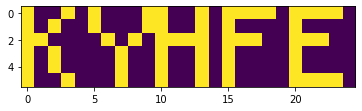

In [40]:
plt.imshow(imagekeeper, interpolation='nearest')
plt.show()

#### Day 9

In [41]:
class IntCode_v3:
    def __init__(self, intcode):
        self.intcode = intcode
        self.reset()
    
    def reset(self):
#         self.work_intcode = self.intcode[:]
        self.work_intcode = {idx:val for idx, val in enumerate(self.intcode)} 
        self.output = []
        self.mem = {}
        
    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as file:
            return cls([int(x) for x in file.read().split(',')])
    
    @classmethod
    def test_txt(cls, text, calc, **input_dict):
        test_intcode = cls([int(x) for x in text.split(',')])
        test_intcode.intcodeRead(calc, outmode = 0, **input_dict)
    
    def mode_manage(self, num, mode):
        if mode == 0:
            return self.work_intcode.get(num, 0)
        elif mode == 1:
            return num
        elif mode == 2:
            return self.work_intcode.get(self.mem['relbase'] + num, 0)
    
    def spec_mode_manage(self, num, mode):
        if mode == 0 or mode == 1:
            return num
        elif mode == 2:
            return self.mem['relbase'] + num
                
    def instr_manage(self, selfmem):      
        current_idx =  selfmem['current_idx']
        
        instr_str = str(self.work_intcode.get(current_idx, 0))
        params = {x:int(y) for x, y in enumerate(reversed(instr_str[:len(instr_str)-2]))}
        opcode = instr_str[len(instr_str)-2:]
        
        
#         print(instr_str, opcode)
        if int(opcode) == 1:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            self.work_intcode[output_loc] = param_a + param_b
            
            current_idx += 4
            
        elif int(opcode) == 2:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            self.work_intcode[output_loc] = param_a * param_b
            
            current_idx += 4

        elif int(opcode) == 3: 
            try:
                move_num = self.spec_mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))            
                self.work_intcode[move_num] = selfmem['inputs'][selfmem['input_idx']]
                selfmem['input_idx'] += 1
            
                current_idx += 2
            except IndexError:
                print('HALT COMMAND')
                selfmem['midhalt'] = 1
        
        elif int(opcode) == 4:
            val_output = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            self.output.append(val_output)
            
            current_idx += 2
        
        elif int(opcode) == 5:
            check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            if check != 0:
                current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 6:
            check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            if check == 0:
                current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 7:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            if param_a < param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
            
            current_idx += 4
        
        elif int(opcode) == 8:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            if param_a == param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
                
            current_idx += 4
        
        elif int(opcode) == 9:
            rel_adj = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            selfmem['relbase'] += rel_adj
                
            current_idx += 2
        
        return current_idx
       
    def intcodeRead(self, calc, outmode = 1, **input_dict):
        current_idx = 0
        
        if self.mem == {}:
            self.mem = input_dict
            self.mem['input_idx'] = 0
            self.mem['midhalt'] = None
            self.mem['current_idx'] = 0
            self.mem['relbase'] = 0
            
            if isinstance(self.mem.get('inputs',0), int):
                self.mem['inputs'] = [self.mem.get('inputs',0)]
        else:
            self.mem['inputs'] = input_dict['inputs']
            self.mem['midhalt'] = 0
#         print(self.output)
             
        if calc == 'nv':
            print(
                f'Calculating using NOUN/VERB method\n' 
                f'Noun: {nv.get("noun", 0)}\n' 
                f'Verb: {nv.get("verb", 0)}\n' 
                f"Note: If noun or verb used in inputs are > 99, noun and verb default to intcode's default values"
            )
            self.work_intcode[1] = self.mem.get('noun', x[1])
            self.work_intcode[2] = self.mem.get('verb', x[2])
            
        elif calc == 'input':
            print(
#                 f'Calculating using input method\n'
#                 f'Note: Default value if "val" variable not in parameters is 0'
            )
        
        while self.work_intcode.get(self.mem['current_idx'], 0) != 99 and self.mem['midhalt'] != 1:
#             print(self.mem['current_idx'])
            self.mem['current_idx'] = self.instr_manage(self.mem)

        reconstituted = [self.work_intcode.get(x, 0) for x in range(max(self.work_intcode)+1)]
        
        if outmode == 1:
            return reconstituted, self.output
        elif outmode == 'output_only':
            return self.output
        elif outmode == 'last_out':
            return self.output[-1]
        else:
            print(reconstituted, self.output, self.mem.get('inputs'))

In [42]:
boost_run = IntCode_v3.load('day09.txt')

In [43]:
boost_run.intcodeRead(calc = 'input', outmode = 0, inputs = 1)


[1102, 34463338, 34463338, 63, 1007, 63, 34463338, 63, 1005, 63, 53, 1102, 3, 1, 1000, 109, 988, 209, 12, 9, 1000, 209, 6, 209, 3, 203, 0, 1008, 1000, 1, 63, 1005, 63, 65, 1008, 1000, 2, 63, 1005, 63, 904, 1008, 1000, 0, 63, 1005, 63, 58, 4, 25, 104, 0, 99, 4, 0, 104, 0, 99, 4, 17, 104, 0, 99, 0, 2204990589, 1101, 0, 31, 1019, 1101, 25, 0, 1008, 1102, 35, 1, 1009, 1102, 422, 1, 1029, 1102, 1, 21, 1005, 1102, 1, 734, 1027, 1102, 29, 1, 1000, 1101, 32, 0, 1018, 1102, 28, 1, 1016, 1101, 0, 38, 1015, 1101, 0, 378, 1023, 1101, 30, 0, 1017, 1102, 1, 381, 1022, 1101, 0, 37, 1006, 1102, 1, 1, 1021, 1101, 0, 24, 1011, 1102, 1, 23, 1002, 1101, 0, 0, 1020, 1101, 0, 20, 1007, 1101, 427, 0, 1028, 1101, 26, 0, 1014, 1101, 27, 0, 1010, 1101, 0, 39, 1001, 1101, 34, 0, 1012, 1102, 1, 36, 1013, 1101, 0, 33, 1003, 1101, 804, 0, 1025, 1101, 737, 0, 1026, 1102, 1, 809, 1024, 1102, 1, 22, 1004, 109, 9, 1201, -7, 0, 63, 1008, 63, 20, 63, 1005, 63, 205, 1001, 64, 1, 64, 1106, 0, 207, 4, 187, 1002, 64, 2, 64,

In [44]:
boost_run.reset()
boost_run.intcodeRead(calc = 'input', outmode = 0, inputs = 2)


[1102, 34463338, 34463338, 63, 1007, 63, 34463338, 63, 1005, 63, 53, 1102, 3, 1, 1000, 109, 988, 209, 12, 9, 1000, 209, 6, 209, 3, 203, 0, 1008, 1000, 1, 63, 1005, 63, 65, 1008, 1000, 2, 63, 1005, 63, 904, 1008, 1000, 0, 63, 1005, 63, 58, 4, 25, 104, 0, 99, 4, 0, 104, 0, 99, 4, 17, 104, 0, 99, 1, 0, 1101, 0, 31, 1019, 1101, 25, 0, 1008, 1102, 35, 1, 1009, 1102, 422, 1, 1029, 1102, 1, 21, 1005, 1102, 1, 734, 1027, 1102, 29, 1, 1000, 1101, 32, 0, 1018, 1102, 28, 1, 1016, 1101, 0, 38, 1015, 1101, 0, 378, 1023, 1101, 30, 0, 1017, 1102, 1, 381, 1022, 1101, 0, 37, 1006, 1102, 1, 1, 1021, 1101, 0, 24, 1011, 1102, 1, 23, 1002, 1101, 0, 0, 1020, 1101, 0, 20, 1007, 1101, 427, 0, 1028, 1101, 26, 0, 1014, 1101, 27, 0, 1010, 1101, 0, 39, 1001, 1101, 34, 0, 1012, 1102, 1, 36, 1013, 1101, 0, 33, 1003, 1101, 804, 0, 1025, 1101, 737, 0, 1026, 1102, 1, 809, 1024, 1102, 1, 22, 1004, 109, 9, 1201, -7, 0, 63, 1008, 63, 20, 63, 1005, 63, 205, 1001, 64, 1, 64, 1106, 0, 207, 4, 187, 1002, 64, 2, 64, 109, 2, 

#### Day 10

##### Part 1

In [45]:
with open('day10.txt', 'r') as file:
#     print(file.readlines())
    asteroid_alias = {}
    refval = 0
    for y, row in enumerate(file.readlines()):
        for x, symbol in enumerate(row.strip()):
            if symbol == '#':
                asteroid_alias[refval] = (x,y)
                refval += 1

In [46]:
def calculate_distance(ast1, ast2):
    ast1 = np.array(ast1) 
    ast2 = np.array(ast2)
  
    distance = np.linalg.norm(np.array(ast1) - np.array(ast2))
    
    return distance
    
def calculate_angle(ast1, ast2):
    ast1 = np.array(ast1) 
    ast2 = np.array(ast2)
    # Convert coordinate sytem from top left (0,0), to asteroid B in relative position to asteroid A (0,0)
    astB_coord = (ast2 - ast1) * [1, -1] # converts y-coordinate

    #calculate degrees based on coordinate of 2nd point
    angle = np.degrees(np.arctan2(*astB_coord))
    
    return angle

In [47]:
# for each asteroid (alias), check all asteroids, keep a dict of angles:distance, and change when a lower distance is found for an angle
ast_output = {alias:{} for alias in asteroid_alias.keys()}

for x, origin in asteroid_alias.items():
    for y, target in asteroid_alias.items():
        sight_angle = calculate_angle(origin, target)
        distance = calculate_distance(origin, target)
        
        if (ast_output[x].get(sight_angle, None) == None) or (ast_output[x].get(sight_angle, None) > distance):
            ast_output[x][sight_angle] = distance

In [48]:
best_asteroid_station = sorted(ast_output, key = lambda x: len(ast_output[x].keys()), reverse=True)[0] #Sort by # of keys
los = len(ast_output[289].keys()) # Length of internal dictionary = Number of asteroids visible
print(f'Asteroid {best_asteroid_station}: {los} asteroids in Line of Sight (including itself)')

Asteroid 289: 284 asteroids in Line of Sight (including itself)


##### Part 1

In [49]:
ast289 = asteroid_alias[289]
relative_to_289 = [(alias, calculate_angle(ast289, coord), calculate_distance(ast289, coord))\
                   for alias, coord in asteroid_alias.items() if alias is not 289]

In [50]:
angledict = defaultdict(list)

for ast in relative_to_289:
    angle = ast[1]
    
    if angle < 0:
        angle = angle + 360

    angledict[angle].append((ast[0], ast[2]))
    angledict[angle] = sorted(angledict[angle], key=lambda x: x[1], reverse=False)
    
range_targets = sorted(angledict.keys())

In [51]:
range_idx = 0
destroyed = 0
target_list = deepcopy(angledict)

for val in range(len(relative_to_289)):
    true_idx = range_idx % len(range_targets)
    current_traj = range_targets[true_idx]
    
    try:
        shot = target_list[current_traj]
        print(f'Destroy count: {destroyed + 1} | Asteroid {shot[0]} destroyed, location {asteroid_alias[shot[0][0]]}, angle {current_traj}')
        shot.pop(0)
        
        destroyed += 1
        range_idx += 1
    
    except IndexError:
        print(f'No more asteroids in angle {current_traj}')
        range_idx += 1
        
        continue  

Destroy count: 1 | Asteroid (289, 0.0) destroyed, location (20, 19), angle 0.0
Destroy count: 2 | Asteroid (12, 19.026297590440446) destroyed, location (21, 0), angle 3.0127875041833403
Destroy count: 3 | Asteroid (56, 16.0312195418814) destroyed, location (21, 3), angle 3.576334374997351
Destroy count: 4 | Asteroid (69, 15.033296378372908) destroyed, location (21, 4), angle 3.8140748342903543
Destroy count: 5 | Asteroid (113, 12.041594578792296) destroyed, location (21, 7), angle 4.763641690726178
Destroy count: 6 | Asteroid (13, 19.1049731745428) destroyed, location (22, 0), angle 6.009005957494525
Destroy count: 7 | Asteroid (153, 9.055385138137417) destroyed, location (21, 10), angle 6.34019174590991
Destroy count: 8 | Asteroid (166, 8.06225774829855) destroyed, location (21, 11), angle 7.125016348901798
Destroy count: 9 | Asteroid (187, 7.0710678118654755) destroyed, location (21, 12), angle 8.13010235415598
Destroy count: 10 | Asteroid (99, 13.152946437965905) destroyed, location

In [52]:
# 200th destroyed asteroid: Alias 60, poistion (4,4)
# Answer is X * 100 + Y = 404

#### Day 11

##### Part 1

In [53]:
class paintBot():
    def __init__(self, int_filename, initposition = [0.,0.]):
        self.direction_ref  = {0: (np.array([0.,1.]), 'up'), 1: (np.array([1.,0.]), 'right'),\
                               2: (np.array([0.,-1.]), 'down'), 3: (np.array([-1.,0.]), 'left')}
        # Keys refer to current face, 0 (up) going in clockwise direction to 3 (left)
        # Values refer to movement method when facing that direction
        
        self.ICprocessor = IntCode_v3.load(int_filename)
        self.reset(initposition)
    
    def reset(self, initposition = [0., 0.]):
        self.ICprocessor.reset()
        
        self.position = np.array(initposition)
        self.face_idx = 0
        self.paintgrid = defaultdict(lambda: 0) # Should keep record of CURRENT canvas status
        self.inss = []
    
    def change_direction(self, dircode):
        idx_mod = np.where(dircode == 0, 1, -1)
        if dircode == 1:
            idx_mod = 1
        elif dircode == 0:
            idx_mod = -1
        
        self.face_idx = (self.face_idx + idx_mod) % 4
    
    def action_step(self):
        input_color = self.paintgrid[self.position.tobytes()]
        # 0 black, 1 white
        # Keys of self.paintgrid will keep memory of how many panels painted at least once
        
        print(f'Position: {self.position}\nFacing {self.direction_ref[self.face_idx][1]}\nCurrent color: {input_color}\n')
        self.inss.append(input_color)
        
        output = self.ICprocessor.intcodeRead(calc='input', outmode = 'output_only', inputs = self.inss)
        output_color = output[-2]
        output_dircode = output[-1]
        
        print(output[-2:])
        
        self.paintgrid[self.position.tobytes()] = output_color
        self.change_direction(output_dircode)
        self.position = self.position + self.direction_ref[self.face_idx][0]
        
       
    def run_paintBot(self, col_1 = 0):
        self.paintgrid[self.position.tobytes()] = col_1
        
        while self.ICprocessor.mem.get('midhalt', 1) == 1:
            self.action_step()    
    

In [54]:
pb = paintBot('day11.txt')

In [55]:
pb.reset()
pb.run_paintBot(col_1 = 0) # bot's starting position color is black (0)

Position: [0. 0.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-1.  0.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [-1.  1.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [0. 1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [0. 2.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-1.  2.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [-1.  3.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-2.  3.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [-2.  2.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [-1.  2.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [-1.  3.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [-2.  3.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [-2.  2.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [-1.  2.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [-1.  1.]


HALT COMMAND
[1, 0]
Position: [-7. -6.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [-7. -5.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [-6. -5.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [-6. -4.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [-7. -4.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [-7. -5.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [-6. -5.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [-6. -4.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-7. -4.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [-7. -5.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [-6. -5.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [-6. -6.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [-5. -6.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [-5. -7.]
Facing down
Current color: 0


HALT C


HALT COMMAND
[0, 1]
Position: [ 3. -5.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 4. -5.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [ 4. -4.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [ 3. -4.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 3. -3.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 2. -3.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [ 2. -4.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 3. -4.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [ 3. -3.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [ 2. -3.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 2. -4.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [ 3. -4.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 3. -3.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 2. -3.]
Facing left
Current color: 1


HALT COMMAND



HALT COMMAND
[0, 1]
Position: [6. 9.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [6. 8.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [7. 8.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [7. 7.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [8. 7.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [8. 8.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [7. 8.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [7. 7.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [8. 7.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [8. 8.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [7. 8.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [7. 7.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [8. 7.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [8. 8.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [7.


HALT COMMAND
[1, 0]
Position: [20.  9.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [20. 10.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [21. 10.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [21.  9.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [22.  9.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [22.  8.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [23.  8.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [23.  7.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [22.  7.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [22.  8.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [21.  8.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [21.  9.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [22.  9.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [22. 10.]
Facing up
Current color: 0


HALT COMM



HALT COMMAND
[1, 0]
Position: [16. 15.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [16. 16.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [17. 16.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [17. 15.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [18. 15.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [18. 14.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [17. 14.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [17. 13.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [16. 13.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [16. 12.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [15. 12.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [15. 11.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [16. 11.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [16. 12.]
Facing up
Current color: 1


HALT 

[1, 0]
Position: [12. -5.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [12. -6.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [13. -6.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [13. -7.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [12. -7.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [12. -6.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [11. -6.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [11. -7.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [12. -7.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [12. -6.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [13. -6.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [13. -5.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [14. -5.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [14. -6.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]


[1, 1]
Position: [20. -1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [20.  0.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [19.  0.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [19.  1.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [18.  1.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [18.  2.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [17.  2.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [17.  3.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [16.  3.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [16.  2.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [17.  2.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [17.  1.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [16.  1.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [16.  0.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Posit

HALT COMMAND
[1, 1]
Position: [24. 14.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [23. 14.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [23. 13.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 13.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 14.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 14.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [25. 15.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 15.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 16.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [25. 16.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 17.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [24. 17.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [24. 16.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [25. 16.]
Facing right
Current color: 1


HALT COMMAND

Position: [18. 19.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [18. 18.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [19. 18.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [19. 17.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [18. 17.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [18. 16.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [17. 16.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [17. 17.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [16. 17.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [16. 16.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [15. 16.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [15. 15.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [16. 15.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [16. 16.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Positio



HALT COMMAND
[1, 1]
Position: [32. 18.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [33. 18.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [33. 17.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [34. 17.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [34. 16.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [33. 16.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [33. 17.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [34. 17.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [34. 16.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [35. 16.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. 15.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [36. 15.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [36. 14.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [37. 14.]
Facing right
Current color: 0


HA

HALT COMMAND
[0, 0]
Position: [48. 18.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [47. 18.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [47. 17.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [46. 17.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [46. 16.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [45. 16.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [45. 17.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [46. 17.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [46. 18.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [45. 18.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [45. 19.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [46. 19.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [46. 20.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [47. 20.]
Facing right
Current color: 0


HALT COMMAND


[1, 1]
Position: [42. 18.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [41. 18.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [41. 19.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 19.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 18.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [39. 18.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [39. 19.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [38. 19.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [38. 18.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. 18.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. 19.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [38. 19.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [38. 18.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [39. 18.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Posit



HALT COMMAND
[1, 1]
Position: [43. -3.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [42. -3.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [42. -2.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [41. -2.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [41. -1.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [42. -1.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [42.  0.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [43.  0.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [43.  1.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [42.  1.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [42.  2.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [41.  2.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [41.  3.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [40.  3.]
Facing left
Current color: 0


HALT COMMAND
[



HALT COMMAND
[0, 0]
Position: [48. -9.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [ 48. -10.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 47. -10.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 47. -11.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 46. -11.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 46. -10.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [ 45. -10.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [45. -9.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [46. -9.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 46. -10.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 47. -10.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [ 47. -11.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [ 48. -11.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 48. -12.]
Facing down
C

HALT COMMAND
[0, 0]
Position: [50. 11.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 12.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 12.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [51. 13.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 13.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 14.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 14.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [51. 15.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 15.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 16.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [49. 16.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 17.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [48. 17.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [48. 18.]
Facing up
Current color: 1


HALT COMMAND
[0, 


HALT COMMAND
[1, 1]
Position: [56. 27.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [56. 26.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [57. 26.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [57. 27.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [58. 27.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [58. 26.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [57. 26.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [57. 27.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [58. 27.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [58. 28.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [59. 28.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [59. 29.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [58. 29.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [58. 28.]
Facing down
Current color: 1


HALT COMM

Position: [52. 24.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 24.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 23.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [52. 23.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [52. 24.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [51. 24.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [51. 23.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 23.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 22.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 22.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 23.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [50. 23.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 24.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [49. 24.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [4

[0, 1]
Position: [36. 29.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [36. 30.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [37. 30.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [37. 29.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [38. 29.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [38. 30.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [39. 30.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [39. 31.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 31.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [40. 32.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [39. 32.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [39. 33.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [38. 33.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [38. 32.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Posit

[0, 1]
Position: [42. 33.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [42. 34.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [41. 34.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [41. 33.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 33.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [40. 32.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [39. 32.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [39. 33.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [40. 33.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 34.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [39. 34.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [39. 35.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 35.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 36.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Positio

[1, 0]
Position: [28. 28.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 28.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 29.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 29.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 28.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 28.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 29.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [24. 29.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [24. 28.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [25. 28.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [25. 29.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 29.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 28.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [25. 28.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Pos

HALT COMMAND
[1, 1]
Position: [19. 32.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [19. 31.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [18. 31.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [18. 32.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [19. 32.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [19. 33.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [18. 33.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [18. 32.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [19. 32.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [19. 31.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [20. 31.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [20. 30.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [19. 30.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [19. 29.]
Facing down
Current color: 0


HALT CO

HALT COMMAND
[1, 1]
Position: [24. 43.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [24. 44.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 44.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 43.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [24. 43.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 42.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [23. 42.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [23. 41.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [22. 41.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [22. 40.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [23. 40.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [23. 39.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 39.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [24. 38.]
Facing down
Current color: 1


HALT

HALT COMMAND
[0, 0]
Position: [25. 47.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [24. 47.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [24. 48.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 48.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [25. 49.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 49.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [26. 50.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [27. 50.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 49.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [28. 49.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [28. 50.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [27. 50.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [27. 49.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 49.]
Facing left
Current color: 0


HALT COMMA

HALT COMMAND
[1, 0]
Position: [36. 56.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. 56.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. 55.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [36. 55.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [36. 54.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. 54.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. 55.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [34. 55.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [34. 54.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [33. 54.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [33. 53.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [32. 53.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [32. 54.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [31. 54.]
Facing left
Current color: 0


HALT COMMAN

[1, 1]
Position: [36. 54.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [35. 54.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [35. 53.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [34. 53.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [34. 52.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [33. 52.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [33. 51.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [32. 51.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [32. 50.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [31. 50.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [31. 51.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [32. 51.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [32. 50.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [33. 50.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]



HALT COMMAND
[1, 1]
Position: [41. 37.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [40. 37.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 36.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [39. 36.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [39. 35.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 35.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [40. 34.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [41. 34.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [41. 35.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [40. 35.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 36.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [41. 36.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [41. 37.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [42. 37.]
Facing right
Current color: 0


HALT C

[0, 1]
Position: [49. 42.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. 43.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 43.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 42.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. 42.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 43.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [50. 43.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [50. 42.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 42.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. 43.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 43.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 44.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [49. 44.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 45.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Positi

[1, 0]
Position: [50. 39.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 38.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [51. 38.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 37.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 37.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 36.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 36.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 35.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [52. 35.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 34.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 34.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 33.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [52. 33.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 32.]
Facing down
Current color: 0


HALT COMMAND
[


HALT COMMAND
[0, 0]
Position: [48. 54.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [47. 54.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [47. 55.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [48. 55.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [48. 54.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [49. 54.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 53.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 53.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 54.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [49. 54.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [49. 53.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 53.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 54.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [49. 54.]
Facing left
Current color: 1


HALT CO



HALT COMMAND
[0, 0]
Position: [40. 55.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [40. 56.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [39. 56.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [39. 57.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [38. 57.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [38. 58.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [39. 58.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [39. 59.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 59.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [40. 60.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [41. 60.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [41. 59.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [42. 59.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [42. 60.]
Facing up
Current color: 0


HALT COMMAND

HALT COMMAND
[1, 1]
Position: [22. 47.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [22. 46.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [21. 46.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [21. 47.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [20. 47.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [20. 48.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [21. 48.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [21. 49.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [20. 49.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [20. 48.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [21. 48.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [21. 49.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [20. 49.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [20. 48.]
Facing down
Current color: 0


HALT COMMAN



HALT COMMAND
[0, 1]
Position: [28. 39.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [28. 40.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [27. 40.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [27. 39.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 39.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [26. 40.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [27. 40.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [27. 41.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [28. 41.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [28. 42.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [27. 42.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 43.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 43.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [26. 42.]
Facing down
Current color: 1


HALT COMMAN



HALT COMMAND
[1, 1]
Position: [33. 32.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [33. 31.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [34. 31.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [34. 32.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [35. 32.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. 31.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [34. 31.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [34. 32.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. 32.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [35. 31.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [34. 31.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [34. 32.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [35. 32.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [35. 33.]
Facing up
Current color: 1


HALT COM

Position: [49. 22.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [49. 23.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [50. 23.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 24.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 24.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 23.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 23.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [52. 24.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [53. 24.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [53. 23.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 23.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 22.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [53. 22.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [53. 21.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Positi



HALT COMMAND
[0, 1]
Position: [58. 20.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [57. 20.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [57. 21.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [56. 21.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [56. 20.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [55. 20.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [55. 19.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [56. 19.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [56. 18.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [57. 18.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [57. 19.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [58. 19.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [58. 18.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [57. 18.]
Facing left
Current color: 1


HALT 



HALT COMMAND
[0, 1]
Position: [43. 17.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [44. 17.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [44. 16.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [45. 16.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [45. 15.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [44. 15.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [44. 16.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [43. 16.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [43. 17.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [42. 17.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [42. 18.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [41. 18.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [41. 17.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [42. 17.]
Facing right
Current color: 0


HALT COMM

In [56]:
len(pb.paintgrid) #paintgrid keeps memory of current board state

2594

##### Part 2

In [57]:
pb.reset()
pb.run_paintBot(col_1 = 1)

Position: [0. 0.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [1. 0.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [ 1. -1.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 2. -1.]
Facing right
Current color: 0


HALT COMMAND
[0, 0]
Position: [2. 0.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [3. 0.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 3. -1.]
Facing down
Current color: 0


HALT COMMAND
[0, 0]
Position: [ 4. -1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [4. 0.]
Facing up
Current color: 0


HALT COMMAND
[0, 1]
Position: [5. 0.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [ 5. -1.]
Facing down
Current color: 0


HALT COMMAND
[0, 0]
Position: [ 6. -1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [6. 0.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [7. 0.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [ 7. -1.]
Fac

[1, 0]
Position: [ 7. -3.]
Facing down
Current color: 0


HALT COMMAND
[0, 1]
Position: [ 6. -3.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 6. -2.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 5. -2.]
Facing left
Current color: 0


HALT COMMAND
[0, 0]
Position: [ 5. -3.]
Facing down
Current color: 0


HALT COMMAND
[0, 1]
Position: [ 4. -3.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 4. -2.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 3. -2.]
Facing left
Current color: 0


HALT COMMAND
[0, 0]
Position: [ 3. -3.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 2. -3.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 2. -2.]
Facing up
Current color: 0


HALT COMMAND
[0, 0]
Position: [ 1. -2.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 1. -3.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 0. -3.]
Facing left
Current color: 0


HALT COMMAND
[0, 0]
Posit

In [58]:
paint_x = []
paint_y = []


for tile in pb.paintgrid.keys():
    recovered = np.frombuffer(tile, count=-1)
    paint_x.append(recovered[0])
    paint_y.append(recovered[1])
    
(min(paint_x), max(paint_x), min(paint_y), max(paint_y)) # get canvas dimensions

(0.0, 42.0, -5.0, 0.0)

In [59]:
all_white_tiles = [np.frombuffer(tile, count=-1) + [0., 5.] for tile, col in pb.paintgrid.items() if col == 1]

In [60]:
canvas = np.zeros(shape=(6,43))
for fill in all_white_tiles:
    canvas[int(fill[1])][int(fill[0])] = 1

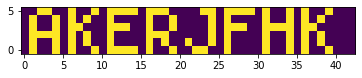

In [61]:
plt.imshow(canvas, interpolation='nearest', origin='lower')
plt.show()

#### Day 12

##### Part 1

In [62]:
def parse_poslines(list_):
    return np.array([[float(num) for num in re.sub(r'[^0-9,-]', '', x).split(',')] for x in list_])

In [63]:
def grav_update(arr1, arr2):
#     print((arr1, arr2, np.where(np.greater(arr1, arr2), -1., 1.)))
    return np.where(np.equal(arr1, arr2), 0., (np.where(np.greater(arr1, arr2), -1., 1.)))

In [64]:
def energy(pos, vel):
    en_list = []
    
    for x in range(len(pos)):
        pot = np.sum(np.abs(pos[x]))
        kin = np.sum(np.abs(vel[x]))
        en_list.append(pot*kin)
#         print(pos[x], pot, vel[x], kin)
    
#     print(en_list)
    return sum(en_list)

In [65]:
def update_step(pos, vel, it):
    
    for pos1, pos2 in itertools.combinations([idx for idx in range(len(pos))], 2):
        arr1 = pos[pos1]
        arr2 = pos[pos2]

        arr1_grav_change = grav_update(arr1, arr2)

        vel[pos1] = vel[pos1] + arr1_grav_change
        vel[pos2] = vel[pos2] - arr1_grav_change
    
    final = np.add(pos, vel)

#     print(f'Step {it+1}')
#     for print1, print2 in zip(final, vel):
#         print(f'{print1}\t\t{print2}')
    
    return final

In [66]:
with open('day12.txt', 'r') as file:
    positions = parse_poslines(file.readlines())

velocity = np.zeros(shape=(4,3))

In [67]:
position_copy = deepcopy(positions)
velocity_copy = deepcopy(velocity)

for it in range(1000):
    position_copy = update_step(position_copy, velocity_copy, it)

print(energy(position_copy, velocity_copy))

9958.0


##### Part 2

In [68]:
cycle_step = defaultdict(lambda: 0)

for idx in range(3):
    print(f'IDX {idx}')
    initial_1dim = np.array([x[idx] for x in positions])
    vel_1dim = np.zeros(shape = (4,))
    
    print(initial_1dim, vel_1dim)

    mem_pos_1dim = []
    mem_val_1dim = []

    while np.array_equal(initial_1dim, mem_pos_1dim) == False:
        if mem_pos_1dim == []:
            mem_pos_1dim = np.copy(initial_1dim)
            mem_val_1dim = np.copy(vel_1dim)
            mem_pos_1dim = update_step(mem_pos_1dim, mem_val_1dim, cycle_step[idx])
            cycle_step[idx] += 1
        else:
            mem_pos_1dim = update_step(mem_pos_1dim, mem_val_1dim, cycle_step[idx])
            cycle_step[idx] += 1

IDX 0
[ 7. -2. 12.  5.] [0. 0. 0. 0.]


C:\Anaconda\envs\advent\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


IDX 1
[10.  7.  5. -8.] [0. 0. 0. 0.]
IDX 2
[17.  0. 12.  6.] [0. 0. 0. 0.]


In [69]:
cycle_step

defaultdict(<function __main__.<lambda>()>, {0: 28481, 1: 231613, 2: 193051})

In [70]:
np.lcm.reduce(np.array([x+1 for x in cycle_step.values()], dtype='int64'))

318382803780324

#### Day 13

##### Part 1

In [71]:
arcade = IntCode_v3.load('day13.txt')

In [72]:
screen = arcade.intcodeRead(calc='input', outmode = 'output_only')

In [73]:
output_screen = {(screen[idx], screen[idx+1]): screen[idx+2] for idx in range(0, len(screen), 3)}
Counter(output_screen.values())

Counter({1: 89, 0: 615, 2: 329, 4: 1, 3: 1})

In [74]:
status_ = defaultdict(list)
for idx in range(0, len(screen), 3):
    status_[screen[idx+2]].append((screen[idx], screen[idx+1]))

In [75]:
output_screen

{(0, 0): 1,
 (1, 0): 1,
 (2, 0): 1,
 (3, 0): 1,
 (4, 0): 1,
 (5, 0): 1,
 (6, 0): 1,
 (7, 0): 1,
 (8, 0): 1,
 (9, 0): 1,
 (10, 0): 1,
 (11, 0): 1,
 (12, 0): 1,
 (13, 0): 1,
 (14, 0): 1,
 (15, 0): 1,
 (16, 0): 1,
 (17, 0): 1,
 (18, 0): 1,
 (19, 0): 1,
 (20, 0): 1,
 (21, 0): 1,
 (22, 0): 1,
 (23, 0): 1,
 (24, 0): 1,
 (25, 0): 1,
 (26, 0): 1,
 (27, 0): 1,
 (28, 0): 1,
 (29, 0): 1,
 (30, 0): 1,
 (31, 0): 1,
 (32, 0): 1,
 (33, 0): 1,
 (34, 0): 1,
 (35, 0): 1,
 (36, 0): 1,
 (37, 0): 1,
 (38, 0): 1,
 (39, 0): 1,
 (40, 0): 1,
 (41, 0): 1,
 (42, 0): 1,
 (43, 0): 1,
 (44, 0): 1,
 (0, 1): 1,
 (1, 1): 0,
 (2, 1): 0,
 (3, 1): 0,
 (4, 1): 0,
 (5, 1): 0,
 (6, 1): 0,
 (7, 1): 0,
 (8, 1): 0,
 (9, 1): 0,
 (10, 1): 0,
 (11, 1): 0,
 (12, 1): 0,
 (13, 1): 0,
 (14, 1): 0,
 (15, 1): 0,
 (16, 1): 0,
 (17, 1): 0,
 (18, 1): 0,
 (19, 1): 0,
 (20, 1): 0,
 (21, 1): 0,
 (22, 1): 0,
 (23, 1): 0,
 (24, 1): 0,
 (25, 1): 0,
 (26, 1): 0,
 (27, 1): 0,
 (28, 1): 0,
 (29, 1): 0,
 (30, 1): 0,
 (31, 1): 0,
 (32, 1): 0,
 (33, 

In [76]:
status_

defaultdict(list,
            {1: [(0, 0),
              (1, 0),
              (2, 0),
              (3, 0),
              (4, 0),
              (5, 0),
              (6, 0),
              (7, 0),
              (8, 0),
              (9, 0),
              (10, 0),
              (11, 0),
              (12, 0),
              (13, 0),
              (14, 0),
              (15, 0),
              (16, 0),
              (17, 0),
              (18, 0),
              (19, 0),
              (20, 0),
              (21, 0),
              (22, 0),
              (23, 0),
              (24, 0),
              (25, 0),
              (26, 0),
              (27, 0),
              (28, 0),
              (29, 0),
              (30, 0),
              (31, 0),
              (32, 0),
              (33, 0),
              (34, 0),
              (35, 0),
              (36, 0),
              (37, 0),
              (38, 0),
              (39, 0),
              (40, 0),
              (41, 0),
              (42, 0),


In [77]:
{x: len(status_[x]) for x in status_}

{1: 89, 0: 615, 2: 329, 4: 1, 3: 1}

##### Part 2

In [78]:
arcade = IntCode_v3.load('day13.txt')
arcade.work_intcode[0] = 2

joystick_seq = []
status = {}
intersect = 0

while intersect != 329:
    current_screen = arcade.intcodeRead(calc='input', outmode = 'output_only', inputs = joystick_seq[:])
    
#     print(arcade.mem)
    
    status = defaultdict(list)
    for idx in range(0, len(current_screen), 3):
        if (current_screen[idx], current_screen[idx+1]) == (-1,0):
            status['score'] = current_screen[idx+2]
        else:
            status[current_screen[idx+2]].append((current_screen[idx], current_screen[idx+1]))   
    # add block monitoring dict (coord): status
    
    intersect = len((set(status[2])).intersection(set(status[0]))) 
    
    ball = status[4][-1]
    paddle = status[3][-1]
    
#     print(f'Ball: {ball}, Paddle: {paddle}')
    
    print(f'Score: {status.get("score", 0)}')
    print(f'{intersect} tiles hit!')
    
    new_input = int(np.where(paddle[0] == ball[0], 0, np.where(paddle[0] > ball[0], -1, 1)))
    # input method: Chase
    # ball delta right, paddle rel left 2b, move right
    # ball delta left, paddle rel right 2b, move left
    # ball delta left, paddle rel lef 2b
    
    joystick_seq.append(new_input)
    
#     print(joystick_seq)
print(f'FINISHED: SCORE = {status.get("score", 0)}')


HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 246
5 tiles hit!

HALT COMMAND
Score: 246
5 tiles hit

Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2362
44 tiles hit!

HALT COMMAND
Score: 2362
44 tiles hit!

HALT COMMAND
Score: 2406
46 tiles hit!

HALT COMMAND


Score: 4252
82 tiles hit!

HALT COMMAND
Score: 4252
82 tiles hit!

HALT COMMAND
Score: 4252
82 tiles hit!

HALT COMMAND
Score: 4252
82 tiles hit!

HALT COMMAND
Score: 4252
82 tiles hit!

HALT COMMAND
Score: 4252
82 tiles hit!

HALT COMMAND
Score: 4252
82 tiles hit!

HALT COMMAND
Score: 4252
82 tiles hit!

HALT COMMAND
Score: 4252
82 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND
Score: 4330
83 tiles hit!

HALT COMMAND


Score: 5147
105 tiles hit!

HALT COMMAND
Score: 5147
105 tiles hit!

HALT COMMAND
Score: 5147
105 tiles hit!

HALT COMMAND
Score: 5147
105 tiles hit!

HALT COMMAND
Score: 5147
105 tiles hit!

HALT COMMAND
Score: 5147
105 tiles hit!

HALT COMMAND
Score: 5147
105 tiles hit!

HALT COMMAND
Score: 5147
105 tiles hit!

HALT COMMAND
Score: 5147
105 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 tiles hit!

HALT COMMAND
Score: 5197
106 

Score: 7616
157 tiles hit!

HALT COMMAND
Score: 7616
157 tiles hit!

HALT COMMAND
Score: 7616
157 tiles hit!

HALT COMMAND
Score: 7616
157 tiles hit!

HALT COMMAND
Score: 7616
157 tiles hit!

HALT COMMAND
Score: 7616
157 tiles hit!

HALT COMMAND
Score: 7616
157 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 

HALT COMMAND
Score: 8462
175 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Score: 8484
176 tiles hit!

HALT COMMAND
Sco

Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9044
191 tiles hit!

HALT COMMAND
Score: 9139
192 tiles hit!

HALT COMMAND
Score: 9139
192 tiles hit!

HALT COMMAND
Score: 9139
192 tiles hit!

HALT COMMAND
Score: 9139
192 tiles hit!

HALT COMMAND
Score: 9139
192 tiles hit!

HALT COMMAND
Score: 9139
192 tiles hit!

HALT COMMAND
Score: 9139
192 tiles hit!

HALT COMMAND
Score: 9139
192 tiles hit!

HALT COMMAND
Score: 9139
192 tiles hit!

HALT COMMAND
Score: 9139
192 

Score: 10177
214 tiles hit!

HALT COMMAND
Score: 10177
214 tiles hit!

HALT COMMAND
Score: 10177
214 tiles hit!

HALT COMMAND
Score: 10177
214 tiles hit!

HALT COMMAND
Score: 10177
214 tiles hit!

HALT COMMAND
Score: 10177
214 tiles hit!

HALT COMMAND
Score: 10177
214 tiles hit!

HALT COMMAND
Score: 10177
214 tiles hit!

HALT COMMAND
Score: 10194
215 tiles hit!

HALT COMMAND
Score: 10194
215 tiles hit!

HALT COMMAND
Score: 10194
215 tiles hit!

HALT COMMAND
Score: 10194
215 tiles hit!

HALT COMMAND
Score: 10194
215 tiles hit!

HALT COMMAND
Score: 10194
215 tiles hit!

HALT COMMAND
Score: 10194
215 tiles hit!

HALT COMMAND
Score: 10194
215 tiles hit!

HALT COMMAND
Score: 10194
215 tiles hit!

HALT COMMAND
Score: 10194
215 tiles hit!

HALT COMMAND
Score: 10234
216 tiles hit!

HALT COMMAND
Score: 10319
217 tiles hit!

HALT COMMAND
Score: 10319
217 tiles hit!

HALT COMMAND
Score: 10319
217 tiles hit!

HALT COMMAND
Score: 10391
218 tiles hit!

HALT COMMAND
Score: 10391
218 tiles hit!

HALT 

Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11682
246 tiles hit!

HALT COMMAND
Score: 11729
247 tiles hit!

HALT COMMAND
Score: 11729
247 tiles hit!

HALT COMMAND
Score: 11729
247 tiles hit!

HALT COMMAND
Score: 11729
247 tiles hit!

HALT COMMAND
Score: 11729
247 tiles hit!

HALT COMMAND
Score: 11729
247 tiles hit!

HALT COMMAND
Score: 11729
247 tiles hit!

HALT COMMAND
Score: 11729
247 tiles hit!

HALT COMMAND
Score: 11729
247 tiles hit!

HALT 

Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12141
258 tiles hit!

HALT COMMAND
Score: 12271
261 tiles hit!

HALT 

Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT COMMAND
Score: 12821
269 tiles hit!

HALT 

Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13138
274 tiles hit!

HALT COMMAND
Score: 13210
275 tiles hit!

HALT COMMAND
Score: 13210
275 tiles hit!

HALT COMMAND
Score: 13210
275 tiles hit!

HALT COMMAND
Score: 13210
275 tiles hit!

HALT COMMAND
Score: 13210
275 tiles hit!

HALT COMMAND
Score: 13210
275 tiles hit!

HALT COMMAND
Score: 13210
275 tiles hit!

HALT 

Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13526
284 tiles hit!

HALT COMMAND
Score: 13572
285 tiles hit!

HALT COMMAND
Score: 13572
285 tiles hit!

HALT COMMAND
Score: 13572
285 tiles hit!

HALT COMMAND
Score: 13572
285 tiles hit!

HALT COMMAND
Score: 13572
285 tiles hit!

HALT COMMAND
Score: 13572
285 tiles hit!

HALT COMMAND
Score: 13572
285 tiles hit!

HALT COMMAND
Score: 13572
285 tiles hit!

HALT COMMAND
Score: 13572
285 tiles hit!

HALT 

Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT 

Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT 

Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT 

Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT COMMAND
Score: 14828
310 tiles hit!

HALT 

Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT 

Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15233
316 tiles hit!

HALT COMMAND
Score: 15233
316 tiles hit!

HALT COMMAND
Score: 15233
316 tiles hit!

HALT COMMAND
Score: 15233
316 tiles hit!

HALT COMMAND
Score: 15233
316 tiles hit!

HALT COMMAND
Score: 15233
316 tiles hit!

HALT COMMAND
Score: 15233
316 tiles hit!

HALT 

Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT 

Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15505
322 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT 

Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT 

Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT 

Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT 

Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT 

Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT 

Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT 

Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

Score: 15973
329 tiles hit!
FINISHED: SCORE = 15973


#### Day 14

##### Part 1

In [191]:
prod_queue = defaultdict(lambda: 0)
act_prod = defaultdict(lambda: 0)
formulas = {}

prod_queue['FUEL'] = 1

In [192]:
with open('day14.txt', 'r') as file:
    for x in file.readlines():
        broken = [x.strip() for x in x.split('=>')]
        
        product = broken[-1].split(' ')
        formulas[product[1]] = {'base_amt': int(product[0]), 'call': 0,\
                                'components': {mat.split(' ')[1] : int(mat.split(' ')[0]) for mat\
                                                in [x.strip() for x in broken[0].split(',')]}}

In [193]:
while 0 != 1:
    flag = 1
    update = defaultdict(lambda: 0)
     
    for fg in [key for key, val in prod_queue.items() if val != 0 and key != 'ORE']:
        must_gen = prod_queue[fg]

        base_prod = formulas[fg]['base_amt']
        cur_call = formulas[fg]['call']
        current_prod = base_prod * cur_call
        
        if current_prod >= must_gen:
            flag += 1
            pass
        else:
            new_prod = must_gen - current_prod
            new_call = math.ceil(new_prod/base_prod)
            
            for component, prod_v in formulas[fg]['components'].items():
                update[component] += new_call * prod_v
            formulas[fg]['call'] += new_call
    
    for fg, val in update.items():
        prod_queue[fg] += val
    
    if flag >= len(prod_queue):
        break

In [195]:
prod_queue['ORE']

843220

##### Part 2

In [276]:
prod_queue2 = defaultdict(lambda: 0)
act_prod2 = defaultdict(lambda: 0)
formulas2 = {}

prod_queue2['FUEL'] = 2000000

In [277]:
with open('day14.txt', 'r') as file:
    for x in file.readlines():
        broken = [x.strip() for x in x.split('=>')]
        
        product = broken[-1].split(' ')
        formulas2[product[1]] = {'base_amt': int(product[0]), 'call': 0,\
                                'components': {mat.split(' ')[1] : int(mat.split(' ')[0]) for mat\
                                                in [x.strip() for x in broken[0].split(',')]}}

In [279]:
while prod_queue2['ORE'] <= 1000000000000:
    flag = 1
    update = defaultdict(lambda: 0)
     
    for fg in [key for key, val in prod_queue2.items() if val != 0 and key != 'ORE']:
        must_gen = prod_queue2[fg]

        base_prod = formulas2[fg]['base_amt']
        cur_call = formulas2[fg]['call']
        current_prod = base_prod * cur_call
        
        if current_prod >= must_gen:
            flag += 1
            pass
        else:
            new_prod = must_gen - current_prod
            new_call = math.ceil(new_prod/base_prod)
            
            for component, prod_v in formulas2[fg]['components'].items():
                update[component] += new_call * prod_v
            formulas2[fg]['call'] += new_call
    
    for fg, val in update.items():
        prod_queue2[fg] += val
        
    if flag >= len(prod_queue2) and prod_queue2['ORE'] >= 1000000000000:
        print(f'FUEL produced: {prod_queue2["FUEL"] - 1}')
        break
    elif flag >= len(prod_queue2):
        if prod_queue2['FUEL'] % 10000 == 0: 
            print(prod_queue2['FUEL'], prod_queue2['ORE'])
        
        prod_queue2['FUEL'] += 1

2000000 921855873581
2010000 926465326122
2020000 931074795858
2030000 935683740012
2040000 940293047739
2050000 944902510909
2060000 949511952686
2070000 954120908771
2080000 958730242772
2090000 963339686393
2100000 967948619321
2110000 972558082780
2120000 977167397079
2130000 981776844286
2140000 986385817190
2150000 990995247562
2160000 995604566838


In [280]:
prod_queue2["FUEL"] - 1

2169535

#### Day 15

In [87]:
mover_bot = IntCode_v3.load('day15.txt')

In [ ]:
start = np.array([0,0])
dir_mover = {1:[0, 1], 2:[0, -1], 3:[-1, 0], 4:[1:0]}

In [96]:
mover_bot.reset()
mover_bot.intcodeRead(outmode = 0, calc = 'input', inputs = [3,1,1,1])


[3, 1, 1, 1] [1, 0, 0, 0]
